# Summary of Imaging Analyses Results

In [1]:
# imports
import os
import polars as pl
import pandas as pd
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from functools import reduce
import operator
from adjustText import adjust_text
import py3Dmol
import polars as pl
from Bio.PDB import PDBParser
from sklearn.cluster import AgglomerativeClustering
import sys
import glob

sns.set_style(style='white')
sys.path.append("../../..")
from utils import *

In [347]:
METADATA_INPUT = "../../../../1_allele_collection/1_inputs"
FEAT_SETS = ["GFP", "DNA", "Mito", "AGP", "Morph"]
INTEGRATIVE_INPUT = "../../../../3_integrated_assay_analyses/1_inputs/imaging"
GFP_MISLOCAL_FEAT_LENIENT = "Altered_95th_perc_both_batches_GFP"
# Original cell imaging profiles
CLASS_RES_OUTDIR = "../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses"
BATCH_LIST_DICT = {
    # "2024_01_23_Batch_7": "2024_02_Batch_7-8", 
    # "2024_02_06_Batch_8": "2024_02_Batch_7-8",
    # "2024_12_09_Batch_11": "2024_12_Batch_11-12", 
    # "2024_12_09_Batch_12": "2024_12_Batch_11-12",
    "2025_01_27_Batch_13": "2025_01_Batch_13-14", 
    "2025_01_28_Batch_14": "2025_01_Batch_13-14",
    # "2025_03_17_Batch_15": "2025_03_Batch_15-16", 
    # "2025_03_17_Batch_16": "2025_03_Batch_15-16"
}
BIO_REP_BATCHES_DICT = {
    "2025_01_Batch_13-14": ("2025_01_27_Batch_13", "2025_01_28_Batch_14")
}

In [243]:
cell_count_summary = pl.read_csv(f"{CLASS_RES_OUTDIR}/2.cell_count_abundance_change/2025_01_Batch_13-14/well-level_cell-count_changes.csv").rename(
    {"U2OS_paired_t_stat": "U2OS_cc_t_stat", "U2OS_paired_t_pval": "U2OS_cc_t_pval", "Variant": "gene_allele"}
)
prot_abund_summary = pl.read_csv(f"{CLASS_RES_OUTDIR}/2.cell_count_abundance_change/2025_01_Batch_13-14/well-level_prot-abundance_changes.csv").rename(
    {"U2OS_paired_t_stat": "U2OS_abun_t_stat", "U2OS_paired_t_pval": "U2OS_abun_t_pval", "Variant": "gene_allele"}
)
auroc_summary_df = pl.read_csv(f"{CLASS_RES_OUTDIR}/3.classification_analyses/2025_01_Batch_13-14/imaging_analyses_classification_summary.csv")
auroc_summary_df = auroc_summary_df.with_columns(
    [pl.col(f"Altered_95th_perc_{feat}").cast(pl.Boolean, strict=False).alias(f"Altered_95th_perc_{feat}") for feat in FEAT_SETS]
)
imaging_summary = cell_count_summary.join(
    prot_abund_summary,
    on=["Gene", "gene_allele"],
    how="full",
    coalesce=True
).join(
    auroc_summary_df,
    on=["Gene", "gene_allele"],
    how="full",
    coalesce=True
).with_columns(
    pl.lit(True).alias("image_assayed"),
    *[
       pl.col(f"AUROC_Mean_{feat}")
       .fill_null(pl.col(f"AUROC_BioRep1_{feat}"))
       .fill_null(pl.col(f"AUROC_BioRep2_{feat}"))
       .alias(f"AUROC_Mean_{feat}")
       for feat in FEAT_SETS  # Assuming you have this list
   ]
).filter(
    pl.col("Gene")!="CCM2"
).rename(
    dict(zip([f"Altered_95th_perc_{feat}" for feat in FEAT_SETS], 
            [f"Altered_95th_perc_both_batches_{feat}" for feat in FEAT_SETS]))
)

clin_var_df = pl.read_csv(f"/home/shenrunx/igvf/varchamp/2025_laval_submitted/1_allele_collection/3_outputs/varchamp_seq_confirm_alleles_clinvar_gnomad_dbnsfp_struc_scores_OMIM_MOI_disease_modules_with_protein_features.tsv",  ##
                          separator="\t", infer_schema_length=1000000
).with_columns(
    pl.col("gene_variant").alias("gene_allele"),
)

imaging_summary_clinvar = imaging_summary.filter(
    ~pl.col("gene_allele").str.contains("CCM2"),
    pl.col("Metadata_Bio_Batch").is_in(["2025_01_Batch_13-14",])
).join(
    clin_var_df.select(["gene_allele"]+[c for c in clin_var_df.columns if c not in imaging_summary.columns]).unique("gene_allele"),
    on=["gene_allele"],
    how="inner"
).with_columns(
    pl.col("clinvar_clnsig_clean").replace("6_No_ClinVar", "5_Others")
)
# with pl.Config(set_tbl_rows=30):
#     display(
#         imaging_summary.filter(
#             ~pl.col("gene_allele").is_in(imaging_summary_clinvar["gene_allele"].unique())
#         )
#     )

In [297]:
prot_abund_summary.filter(
    pl.col("U2OS_abun_t_pval")<0.05,
    pl.col("Gene")!="CCM2"
)

shape: (201, 4)
┌───────┬─────────────────┬──────────────────┬──────────────────┐
│ Gene  ┆ gene_allele     ┆ U2OS_abun_t_stat ┆ U2OS_abun_t_pval │
│ ---   ┆ ---             ┆ ---              ┆ ---              │
│ str   ┆ str             ┆ f64              ┆ f64              │
╞═══════╪═════════════════╪══════════════════╪══════════════════╡
│ SDHD  ┆ SDHD_His102Pro  ┆ 0.475944         ┆ 0.008573         │
│ RAF1  ┆ RAF1_Leu613Val  ┆ 5.723556         ┆ 0.002246         │
│ RAF1  ┆ RAF1_Leu603Pro  ┆ -2.761224        ┆ 0.028914         │
│ SHOC2 ┆ SHOC2_Thr494Asn ┆ 6.245201         ┆ 0.000763         │
│ SDHD  ┆ SDHD_Asp92Gly   ┆ -4.989322        ┆ 0.027997         │
│ …     ┆ …               ┆ …                ┆ …                │
│ ZC4H2 ┆ ZC4H2_Arg198Gln ┆ 7.05355          ┆ 0.000202         │
│ ZC4H2 ┆ ZC4H2_Arg211Trp ┆ 7.731853         ┆ 0.000113         │
│ ZC4H2 ┆ ZC4H2_Arg213Trp ┆ 5.315249         ┆ 0.001105         │
│ ZC4H2 ┆ ZC4H2_Ile7Val   ┆ 6.065889         ┆ 0.000508         │
│ ZC4H2 ┆ ZC4H2_Leu66His  ┆ 5.090199         ┆ 0.001415         │
└───────┴─────────────────┴──────────────────┴──────────────────┘

## 1. Import from 1% paper output

In [8]:
# clin_var_df = pl.read_csv(f"/home/shenrunx/igvf/varchamp/2025_laval_submitted/1_allele_collection/3_outputs/varchamp_seq_confirm_alleles_clinvar_gnomad_dbnsfp_struc_scores_OMIM_MOI_disease_modules_with_protein_features.tsv",  ##
#                           separator="\t", infer_schema_length=1000000
# ).with_columns(
#     pl.col("gene_variant").alias("gene_allele"),
# )
# cell_count_summary = pl.read_csv(f"{CLASS_RES_OUTDIR}/2.cell_count_abundance_change/2025_01_Batch_13-14/well-level_cell-count_changes.csv").rename(
#     {"U2OS_paired_t_stat": "U2OS_cc_t_stat", "U2OS_paired_t_pval": "U2OS_cc_t_pval", "Variant": "gene_allele"}
# )
# prot_abund_summary = pl.read_csv(f"{CLASS_RES_OUTDIR}/2.cell_count_abundance_change/2025_01_Batch_13-14/well-level_prot-abundance_changes.csv").rename(
#     {"U2OS_paired_t_stat": "U2OS_abun_t_stat", "U2OS_paired_t_pval": "U2OS_abun_t_pval", "Variant": "gene_allele"}
# )
# auroc_summary_df = pl.read_csv(f"{CLASS_RES_OUTDIR}/3.classification_analyses/2025_01_Batch_13-14/imaging_analyses_classification_summary.csv")
# imaging_summary = pl.read_csv("/home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/3_outputs/imaging_analyses_summary_clinvar.tsv",
#                              separator="\t", infer_schema_length=10000)

In [9]:
# imaging_summary = imaging_summary.with_columns(
#     pl.lit(True).alias("image_assayed")
# )
# imaging_summary_clinvar = imaging_summary.filter(
#     ~pl.col("gene_allele").str.contains("CCM2"),
#     pl.col("Metadata_Bio_Batch").is_in(["2025_01_Batch_13-14",])
# ).with_columns(
#     pl.col("clinvar_clnsig_clean").replace("6_No_ClinVar", "5_Others")
# ).join(
#     clin_var_df.select(["gene_allele"]+[c for c in clin_var_df.columns if c not in imaging_summary.columns]).unique("gene_allele"),
#     on=["gene_allele"],
#     how="inner"
# )
# imaging_summary_clinvar = imaging_summary_clinvar.with_columns(
#     pl.col("Gene").str.replace_all(r"[^A-Za-z0-9\.]", "").alias("Gene"),
#     pl.col("gene_allele").str.replace_all(r"[^A-Za-z0-9\.]", "").alias("gene_variant") 
# )
# # imaging_summary_clinvar

In [67]:
imaging_summary_clinvar_hits = imaging_summary_clinvar.filter(
    pl.col(GFP_MISLOCAL_FEAT_LENIENT)==1
)
# imaging_summary_clinvar_hits.shape

In [18]:
# imaging_summary_clinvar.write_csv("../../3_outputs/2_results_summary/imaging_analyses_summary_clinvar.tsv", separator="\t")
# imaging_summary_clinvar.write_csv("../../../../3_integrated_assay_analyses/1_inputs/imaging/imaging_analyses_summary_clinvar.tsv", separator="\t")

## 2. Plots

In [244]:
df = imaging_summary_clinvar.to_pandas() ## drop_nulls("clinvar_clnsig_clean").
# Count category frequencies
# Sort categories if you want specific order
category_order = sorted(df["clinvar_clnsig_clean"].unique())

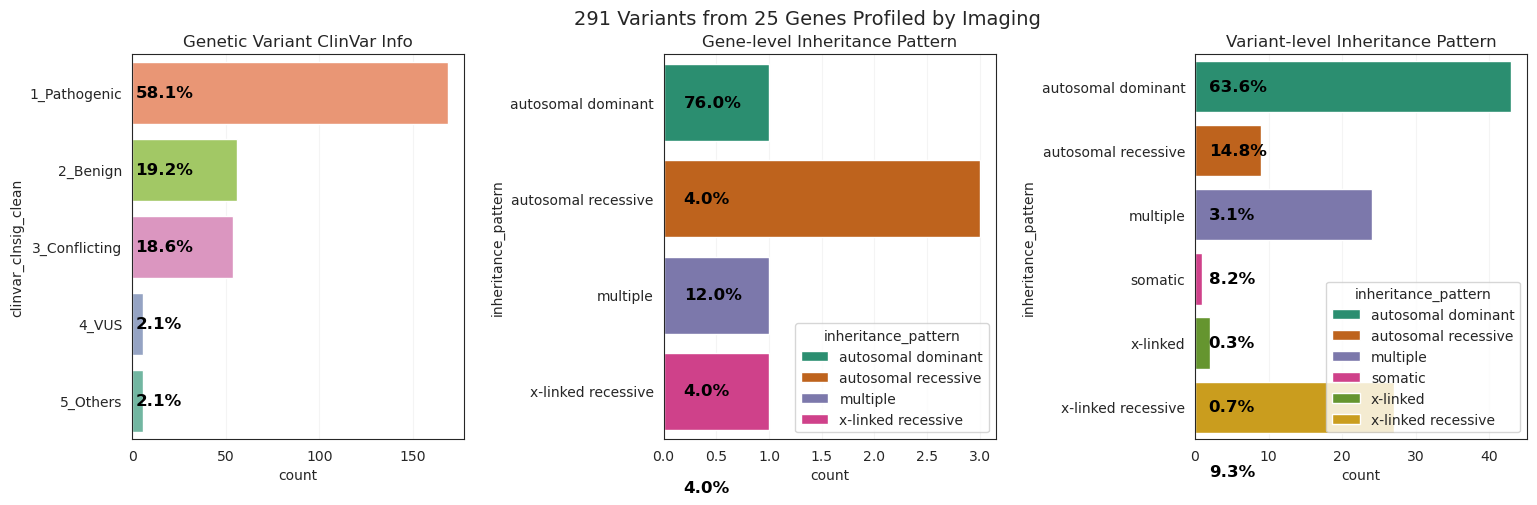

In [245]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
plot_cat_count_perc(
    imaging_summary_clinvar,
    "clinvar_clnsig_clean",
    title="ClinVar",
    ax=axes[0],
    palette=palette_dict["clinvar_clnsig_clean"]
)
axes[0].set_title("Genetic Variant ClinVar Info")

plot_cat_count_perc(
    imaging_summary_clinvar.unique("symbol"),
    "inheritance_pattern",
    title="Inheritance",
    ax=axes[1],
)
axes[1].set_title("Gene-level Inheritance Pattern")

plot_cat_count_perc(
    imaging_summary_clinvar,
    "inheritance_pattern",
    title="Inheritance",
    ax=axes[2],
)
axes[2].set_title("Variant-level Inheritance Pattern")

plt.suptitle(f"{imaging_summary_clinvar.unique('gene_allele').shape[0]} Variants from {imaging_summary_clinvar.unique('symbol').shape[0]} Genes Profiled by Imaging", y=.97, fontsize=14)
plt.subplots_adjust(wspace=.6)
plt.show()

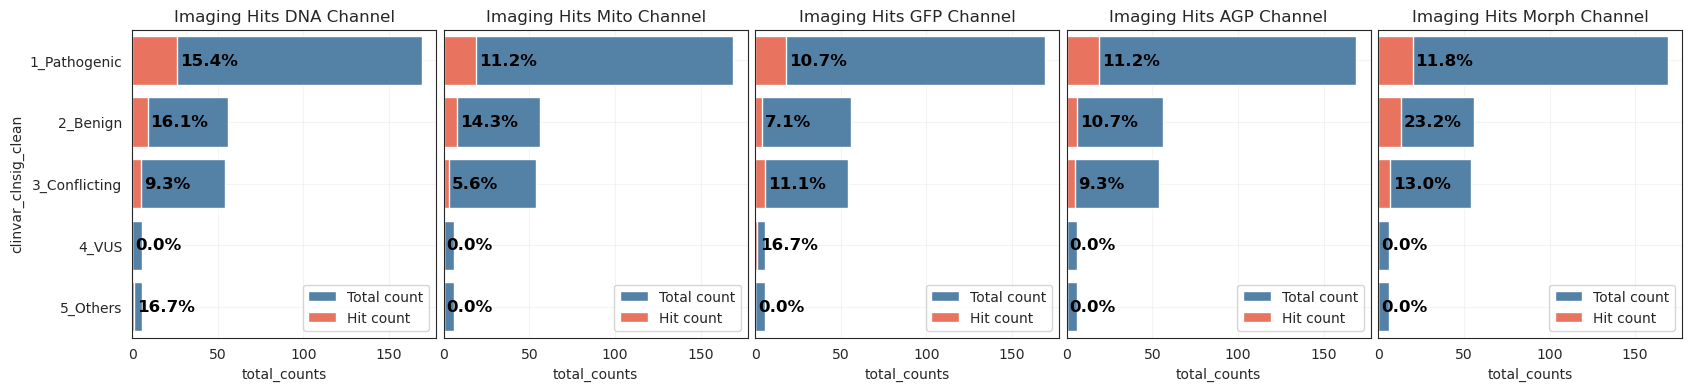

In [246]:
fig, axes = plt.subplots(1,5, figsize=(20,4), sharey=True)
for i, ax in enumerate(axes.flatten()):
    plot_assay_hit_by_category(imaging_summary_clinvar, f"Altered_95th_perc_both_batches_{FEAT_SETS[i]}", 
                               "clinvar_clnsig_clean", f"Imaging Hits {FEAT_SETS[i]} Channel", ax=ax)
plt.subplots_adjust(wspace=.025)
plt.show()

Text(0.5, 1.0, 'Genes Without Mislocalized Variants')

<Figure size 640x480 with 0 Axes>

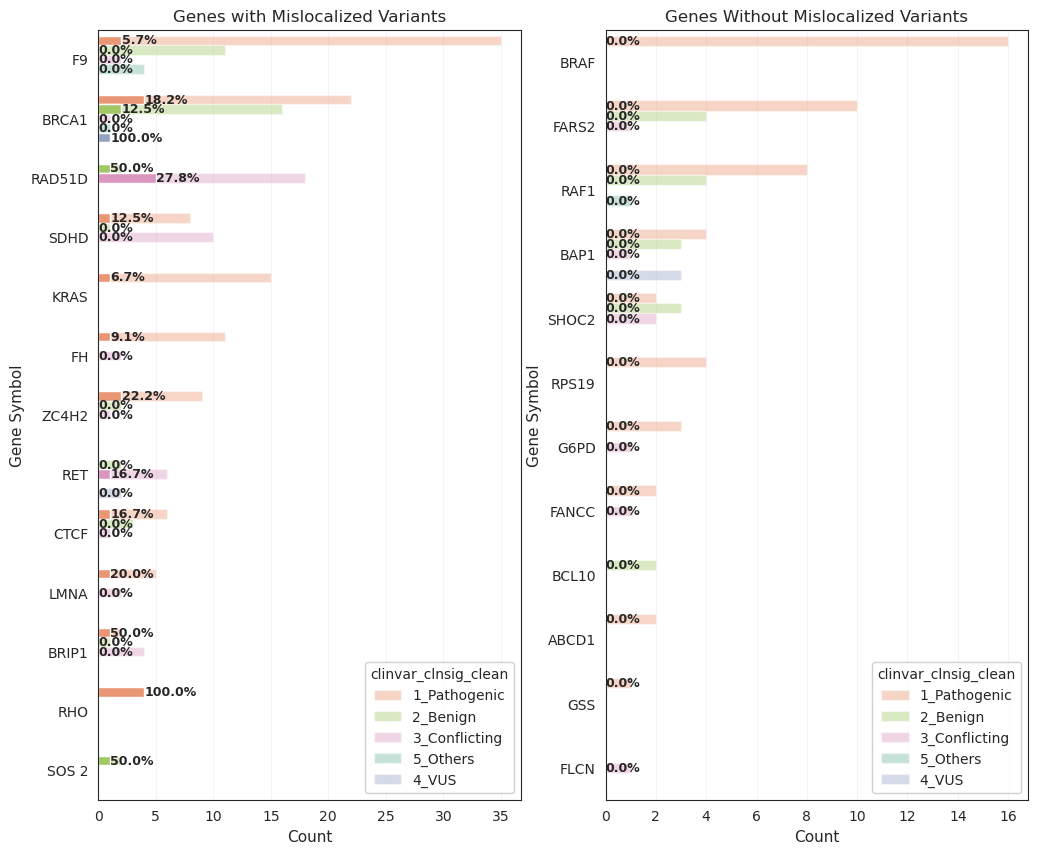

In [247]:
plt.clf()
fig, ax = plt.subplots(1,2,figsize=(12, 10))
plot_gene_level_summary(
    imaging_summary_clinvar.with_columns(
        (
            (pl.col(GFP_MISLOCAL_FEAT_LENIENT)==1)
        ).alias("hit_by_an_assay")
    ).filter(
        pl.col("Gene").is_in(imaging_summary_clinvar_hits["Gene"].unique())
    ),
    assay="hit_by_an_assay", 
    cat="clinvar_clnsig_clean", 
    palette=palette_dict["clinvar_clnsig_clean"],
    ax=ax[0]
)
ax[0].set_title("Genes with Mislocalized Variants")

_ = plot_gene_level_summary(
    imaging_summary_clinvar.with_columns(
        (
            (pl.col(GFP_MISLOCAL_FEAT_LENIENT)==1)
        ).alias("hit_by_an_assay")
    ).filter(
        ~pl.col("Gene").is_in(imaging_summary_clinvar_hits["Gene"].unique())
    ),
    assay="hit_by_an_assay", 
    cat="clinvar_clnsig_clean", 
    palette=palette_dict["clinvar_clnsig_clean"],
    ax=ax[1]
)
ax[1].set_title("Genes Without Mislocalized Variants")

<Figure size 640x480 with 0 Axes>

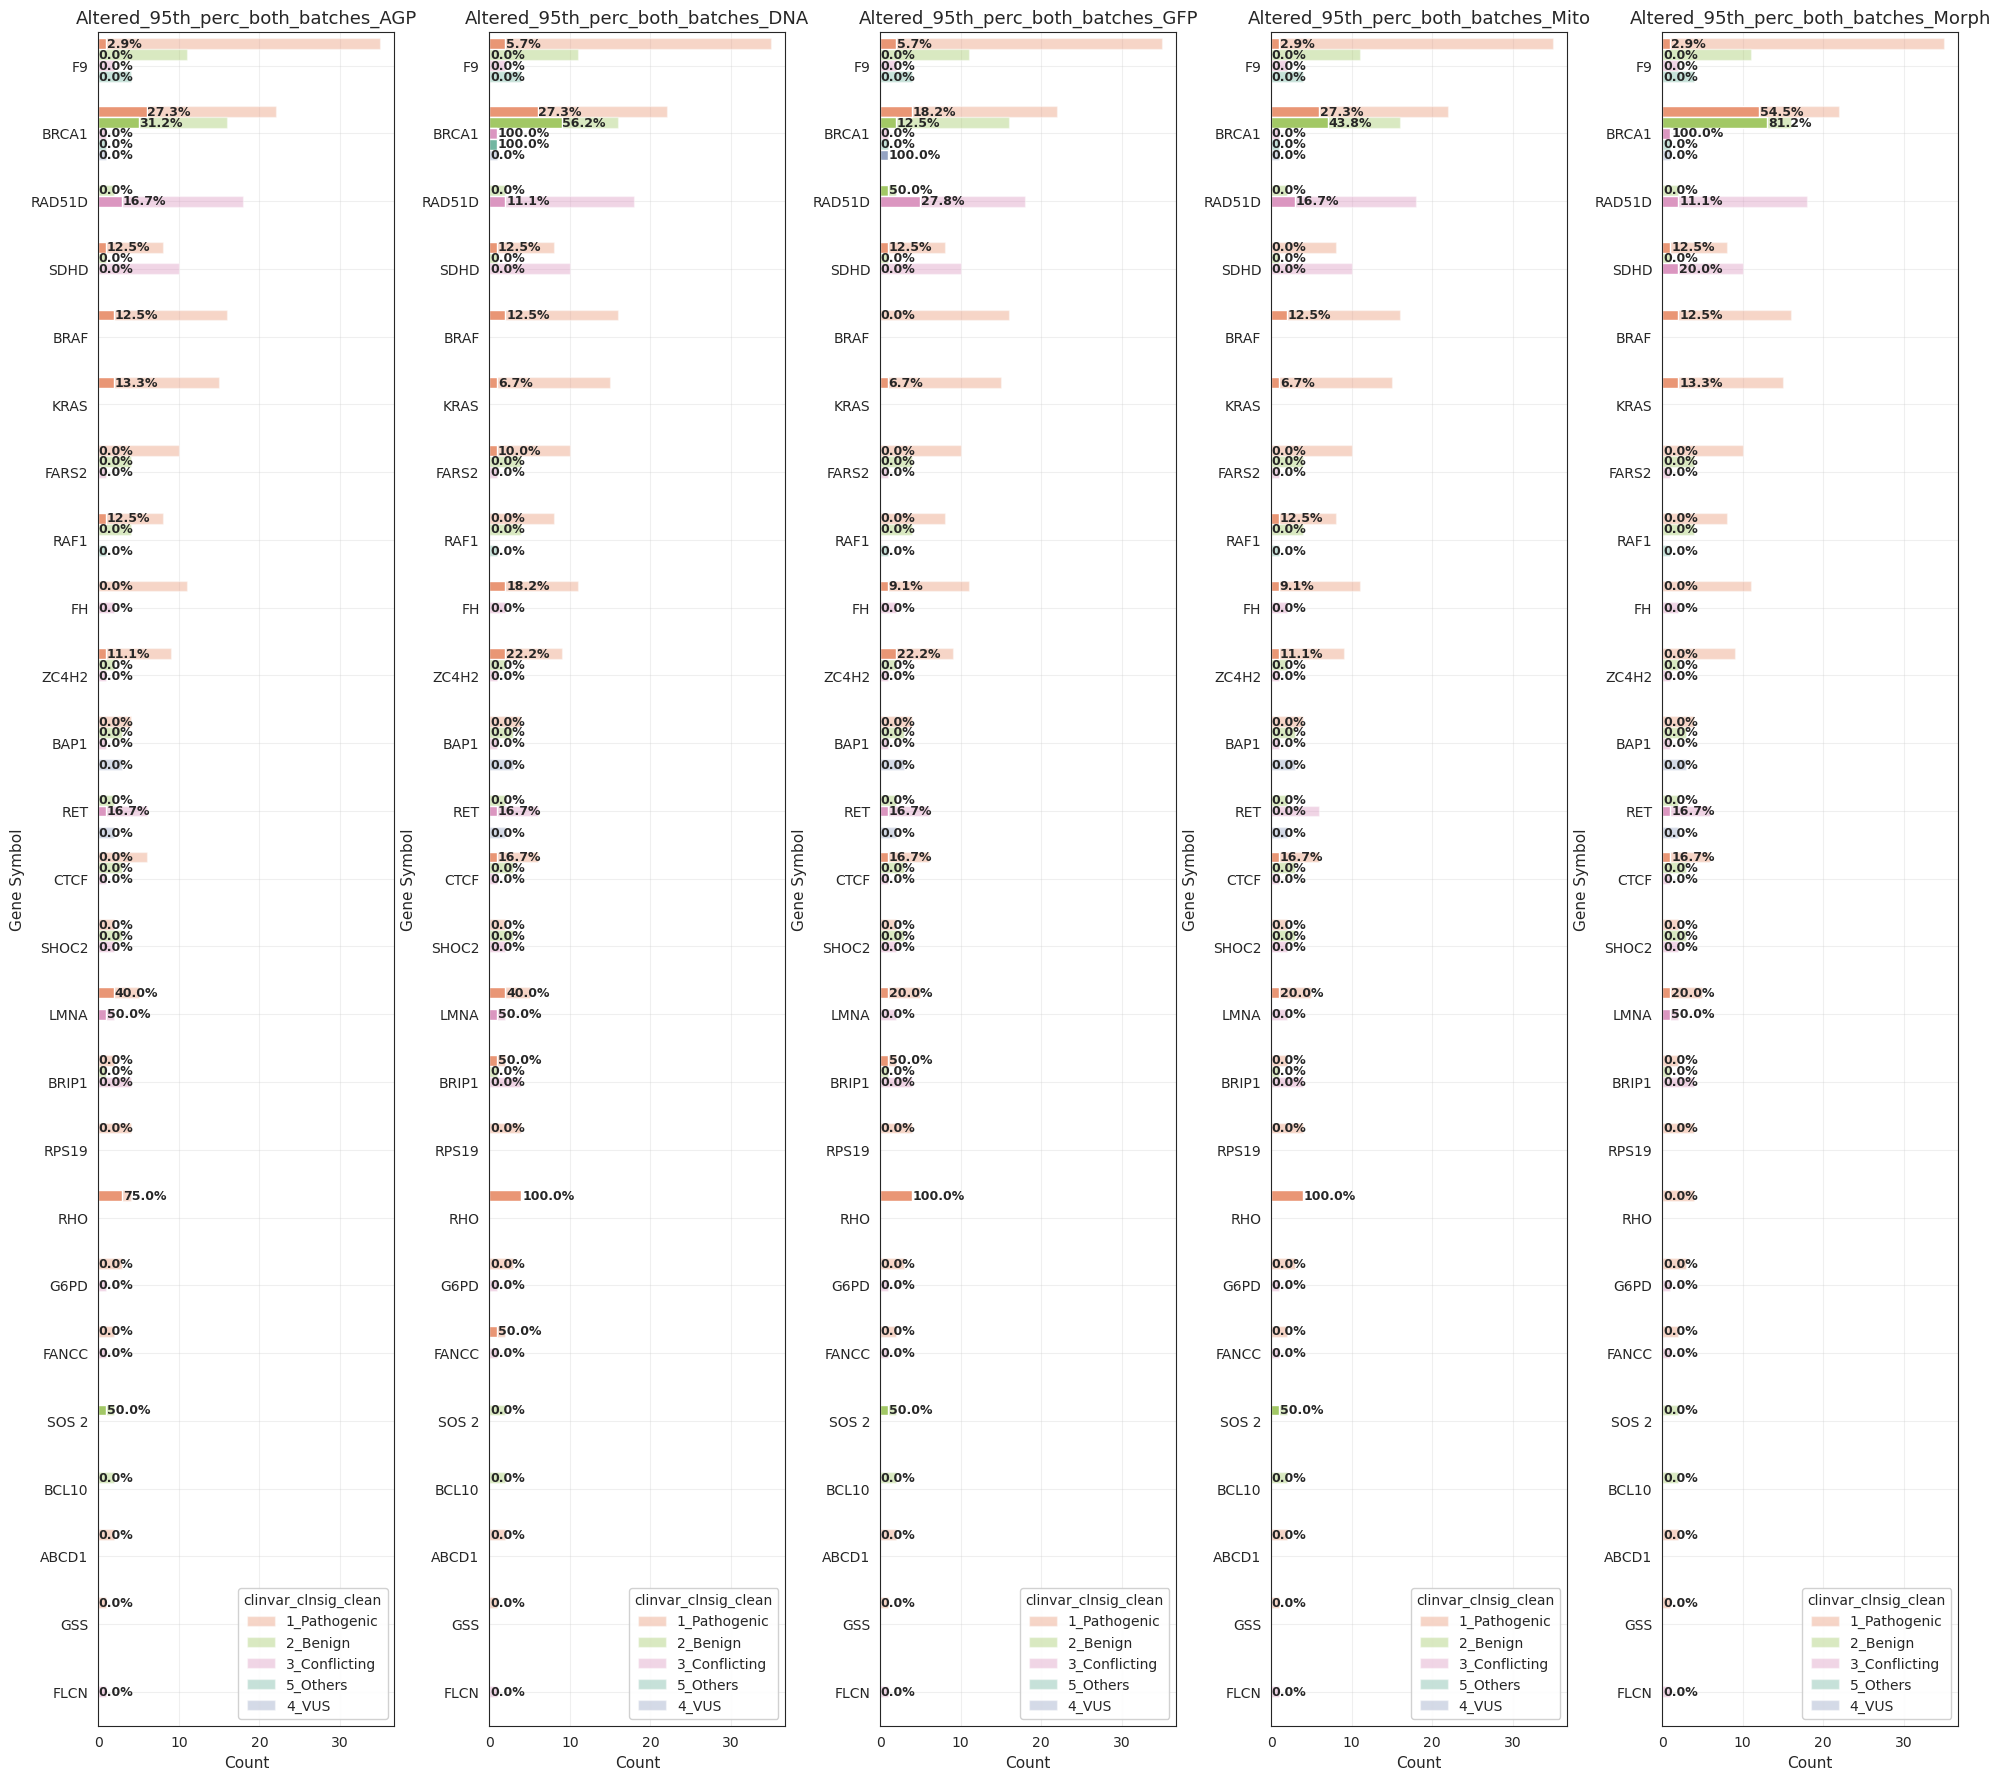

In [248]:
hue_order = sorted(imaging_summary_clinvar.drop_nulls("clinvar_clnsig_clean").unique("clinvar_clnsig_clean")["clinvar_clnsig_clean"])
gene_order = imaging_summary_clinvar.unique("gene_variant").group_by("Gene").agg(
    pl.len()
).sort("len", descending=False)["Gene"]
auroc_cols = sorted([col for col in imaging_summary_clinvar.columns if col.startswith("AUROC_Mean") and not col.endswith("_right")])
alter_95th_cols = sorted([col for col in imaging_summary_clinvar.columns if col.startswith("Altered_95th_perc") and not col.endswith("_right")])
plt.clf()

fig, ax = plt.subplots(1,5,figsize=(24, 22))
for i, col in enumerate(alter_95th_cols):
    plot_gene_level_summary(imaging_summary_clinvar.unique("gene_variant").with_columns(
        pl.col(col).cast(pl.Boolean).alias(col)
    ), assay=col, ax=ax[i], palette=palette_dict["clinvar_clnsig_clean"]) ## gene_order=gene_order, hits_only=False,, col, col+"\n"
    ax[i].grid(alpha=.3)

plt.subplots_adjust(wspace=.32)
plt.show()

<Figure size 640x480 with 0 Axes>

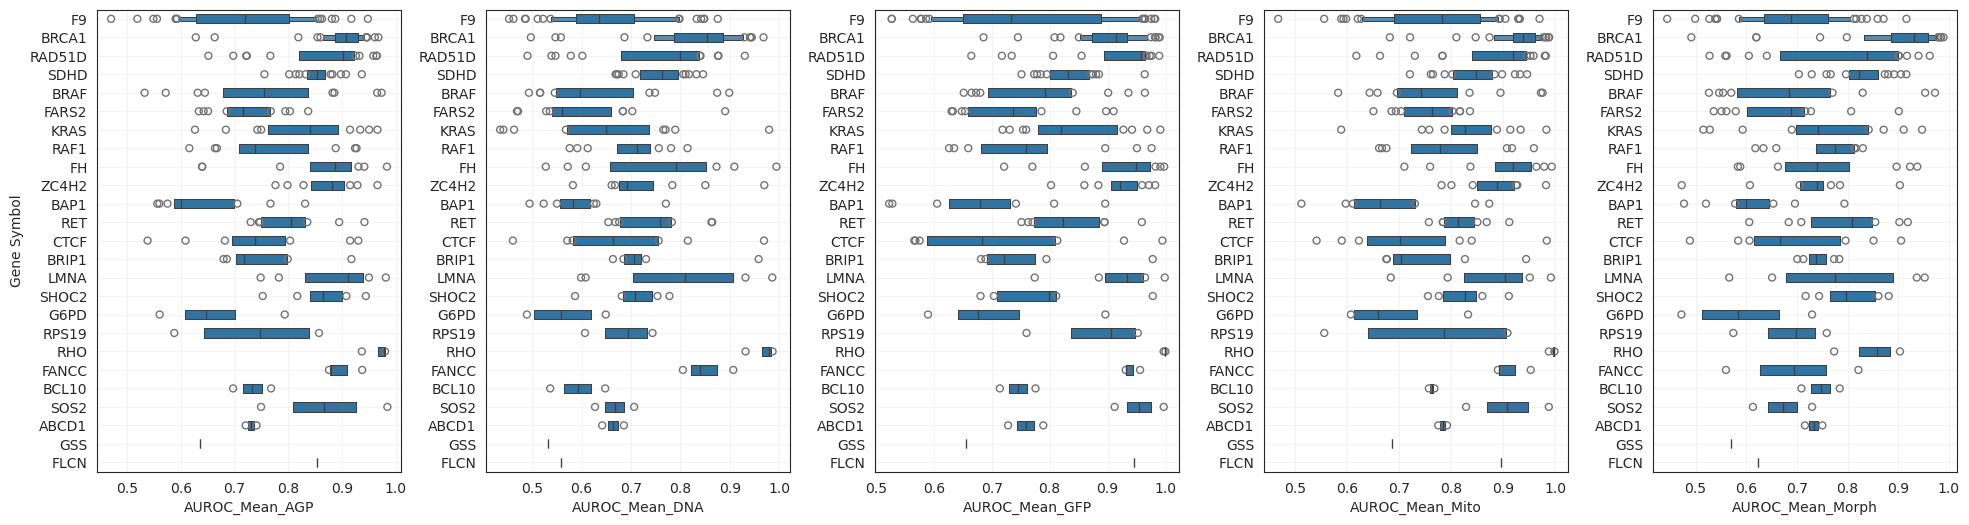

In [249]:
plt.clf()
fig, ax = plt.subplots(1,5,figsize=(24, 6))
for i, col in enumerate(auroc_cols):
    sns.boxenplot(data=imaging_summary_clinvar.unique("gene_variant").to_pandas(), x=col, y="Gene", ax=ax[i], width=.5, 
                 order=gene_order[::-1])
    # ax.set_xlabel("AUROC_Mean_GFP")
    ax[i].set_ylabel("")
    ax[i].grid(alpha=0.2)
ax[0].set_ylabel("Gene Symbol")
plt.subplots_adjust(wspace=.28)
plt.show()

## 3. Pillar overlap

In [250]:
pillar_clinvar_df = pl.read_csv(
    "../../../../1_allele_collection/1_inputs/raw_inputs/pillar_data/final_pillar_data_with_clinvar_gnomad_wREVEL_wAM_gold_standards_080425.csv", 
    schema_overrides={
        "Chrom": pl.String, 
        'aa_pos': pl.String, 
        'auth_reported_score': pl.String
    },
    infer_schema_length=10000
).with_columns(
    pl.col("Gene").str.replace_all(r"[^a-zA-Z0-9]", "").alias("Gene"),
    pl.col("hgvs_p").str.replace_all(r"[^a-zA-Z0-9\.]", "").alias("hgvs_p")
).with_columns(
    pl.col("Chrom").cast(pl.String).str.strip_chars().alias("Chrom"),
    pl.col("hg38_start").alias("nuc_loc"),
    pl.col("ref_allele").cast(pl.String).str.strip_chars().alias("ref_allele"),
    pl.col("alt_allele").cast(pl.String).str.strip_chars().alias("alt_allele")
).with_columns(
    pl.concat_str(
        [
            pl.col("Gene"),
            pl.col("hgvs_p").str.replace(r"^p\.", "") # remove leading "p." from hgvs_p
        ],
        separator="_"
    ).alias("gene_variant")
)
print("Number of unique genes Pillar ALL:", pillar_clinvar_df.unique(subset="Gene").shape[0])
print("Number of unique gene variants Pillar ALL:", pillar_clinvar_df.unique(subset="gene_variant").shape[0])

## filter the SNP variants only
pillar_clinvar_single_aa_df = pillar_clinvar_df.filter(
    (pl.col("consequence").str.contains("sense")) & \
    (pl.col("ref_allele").str.len_chars()==1) & (pl.col("alt_allele").str.len_chars()==1) & \
    (pl.col("hg38_start").is_not_null()) & (pl.col("hg38_end").is_not_null())
).drop_nulls(subset="hgvs_p").with_columns(
    pl.col("hgvs_p").str.split(".").list.get(-1).alias("aa_change")
).sort(
    "gene_variant", "gnomad_MAF", descending=[False,False]
)
print("Filtered missense/SNP pillar dataset shape:", pillar_clinvar_single_aa_df.shape)
print("Number of unique genes Pillar SNP:", pillar_clinvar_single_aa_df.unique(subset="Gene").shape[0])
print("Number of unique gene variants:", pillar_clinvar_single_aa_df.unique(subset="gene_variant").shape[0])
# display(pillar_clinvar_single_aa_df) #.filter(pl.col("Ref_seq_transcript_ID").str.contains("NC_"))

Number of unique genes Pillar ALL: 40
Number of unique gene variants Pillar ALL: 215341
Filtered missense/SNP pillar dataset shape: (176277, 108)
Number of unique genes Pillar SNP: 40
Number of unique gene variants: 94200


### 3.1 Merge by Genomic Position

Text(0.5, 1.0, '123 variants per gene overlapped\nbetween VarChAMP Imaging and Pillar dataset')

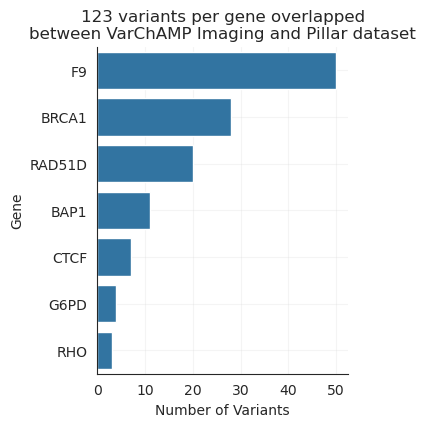

In [252]:
imaging_summary_clinvar_pillar_snp_match_df = imaging_summary_clinvar.join(
    pillar_clinvar_single_aa_df,
    on=["Chrom", "nuc_loc", "ref_allele", "alt_allele"],
    suffix="_pp",
    how="inner"
)
# .filter(
#     pl.col("gene_allele")==pl.col("gene_variant_pp")
# )
# .filter(
#     pl.col("Dataset").str.contains("_unpublished")
# )
imaging_summary_clinvar_pillar_snp_match_df.unique("gene_allele").shape

g = sns.catplot(data=imaging_summary_clinvar_pillar_snp_match_df.unique(subset="gene_variant").group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
            x="Number of Variants", y="Gene", kind="bar", height=4, aspect=.9)
g.ax.grid(alpha=.2)
plt.title(f"{imaging_summary_clinvar_pillar_snp_match_df.unique('gene_allele').shape[0]} variants per gene overlapped\nbetween VarChAMP Imaging and Pillar dataset")

#### Overall Pillar's Author-reported functional class vs Imaging Mislocalization and Morphology Scores 

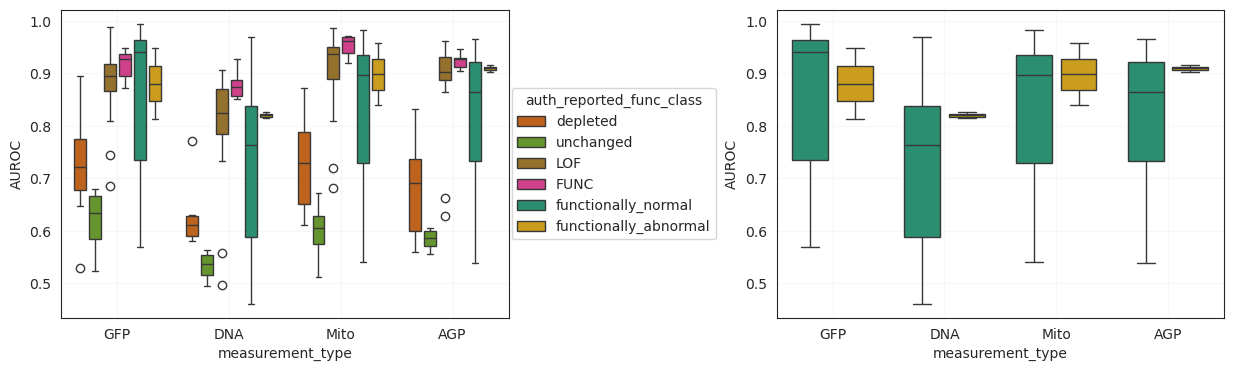

In [350]:
fig, axes = plt.subplots(1,2,figsize=(15,4))
color_palette = dict(zip(
    imaging_summary_clinvar_pillar_snp_match_df["auth_reported_func_class"].sort().unique(),
    sns.color_palette("Dark2")[:len(imaging_summary_clinvar_pillar_snp_match_df["auth_reported_func_class"].unique())]
))
sns.boxplot(
    data=imaging_summary_clinvar_pillar_snp_match_df.select([
        col for col in imaging_summary_clinvar_pillar_snp_match_df.columns 
        if imaging_summary_clinvar_pillar_snp_match_df.select(pl.col(col).is_null().all()).item() is False
    ]).unpivot(
       index=["auth_reported_func_class"],
       on=[f"AUROC_Mean_{feat}" for feat in FEAT_SETS],
       variable_name="measurement_type",
       value_name="AUROC"
    ).with_columns(
       pl.col("measurement_type").str.split("_").list.last().alias("measurement_type")
    ).to_pandas(),
    x="measurement_type",
    y="AUROC",
    hue="auth_reported_func_class",
    gap=.2,
    palette=color_palette,
    ax=axes[0],
    legend=True
)
axes[0].legend(loc="center right", bbox_to_anchor=(1.48,0.5), title="auth_reported_func_class")

sns.boxplot(
    data=imaging_summary_clinvar_pillar_snp_match_df.filter(
        pl.col("Dataset").str.contains("_unpublished")
    ).select([
        col for col in imaging_summary_clinvar_pillar_snp_match_df.columns 
        if imaging_summary_clinvar_pillar_snp_match_df.select(pl.col(col).is_null().all()).item() is False
    ]).unpivot(
       index=["auth_reported_func_class"],
       on=[f"AUROC_Mean_{feat}" for feat in FEAT_SETS],
       variable_name="measurement_type",
       value_name="AUROC"
    ).with_columns(
       pl.col("measurement_type").str.split("_").list.last().alias("measurement_type")
    ).to_pandas(),
    x="measurement_type",
    y="AUROC",
    hue="auth_reported_func_class",
    gap=.2,
    palette=color_palette,
    ax=axes[1],
    legend=False
)
plt.subplots_adjust(wspace=.6)
for ax in axes:
    ax.grid(alpha=.15)

['BAP1_Glu31Lys', 'BAP1_Cys91Ser', 'BAP1_Arg59Pro', 'BAP1_Asn290Ser', 'BAP1_Thr93Ala', 'BAP1_Cys91Gly', 'BAP1_Arg718Gln', 'BAP1_Leu49Pro', 'BAP1_Thr423Lys', 'BAP1_Ser596Gly', 'BAP1_Pro12Thr']
['BRCA1_Arg71Lys', 'BRCA1_Cys61Gly', 'BRCA1_Met1Thr', 'BRCA1_His41Arg', 'BRCA1_Phe591Leu', 'BRCA1_Ser611Arg', 'BRCA1_Val632Ala', 'BRCA1_Thr587Arg', 'BRCA1_Met1Ile', 'BRCA1_Asp67Tyr', 'BRCA1_Cys64Ser', 'BRCA1_Gly666Val', 'BRCA1_Gly602Ala', 'BRCA1_Pro510Ser', 'BRCA1_Thr581Ala', 'BRCA1_Pro533Leu', 'BRCA1_Cys44Tyr', 'BRCA1_Met671Lys', 'BRCA1_Met548Ile', 'BRCA1_Arg71Gly', 'BRCA1_Lys502Glu', 'BRCA1_Glu631Lys', 'BRCA1_Phe558Ser', 'BRCA1_Cys39Arg', 'BRCA1_Leu660Pro', 'BRCA1_Thr37Lys', 'BRCA1_Thr581Ile', 'BRCA1_Cys64Tyr']
['CTCF_Arg342Cys', 'CTCF_His455Gln', 'CTCF_Arg567Leu', 'CTCF_Arg567Trp', 'CTCF_Tyr407Cys', 'CTCF_Arg342Gly', 'CTCF_Ala697Thr']
['G6PD_Glu398Lys', 'G6PD_Ile48Thr', 'G6PD_Arg365His', 'G6PD_Gly378Ser']
['RAD51D_Ile17Val', 'RAD51D_Val28Leu', 'RAD51D_Phe305Leu', 'RAD51D_Ile251Val', 'RAD51D_Arg

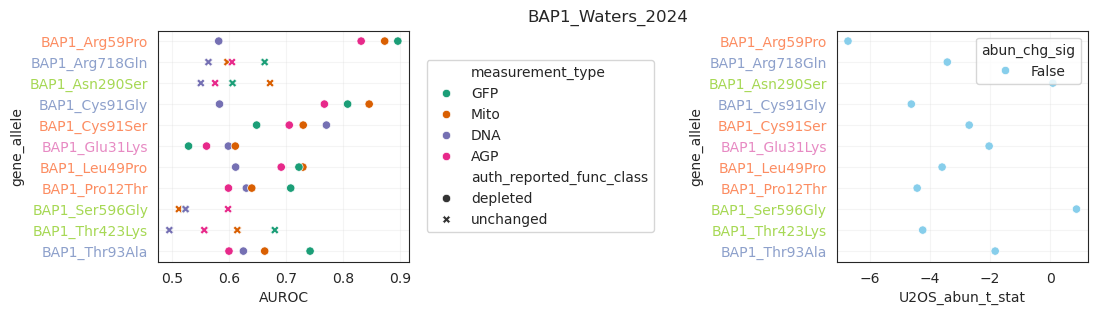

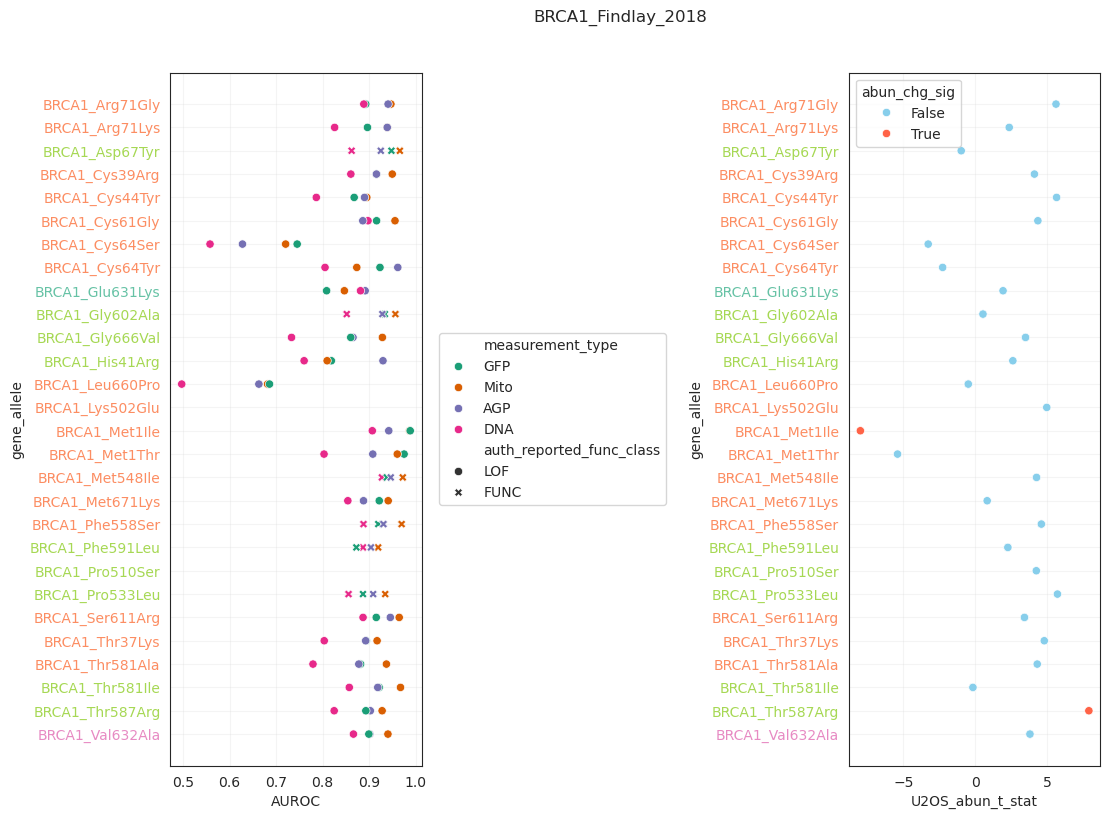

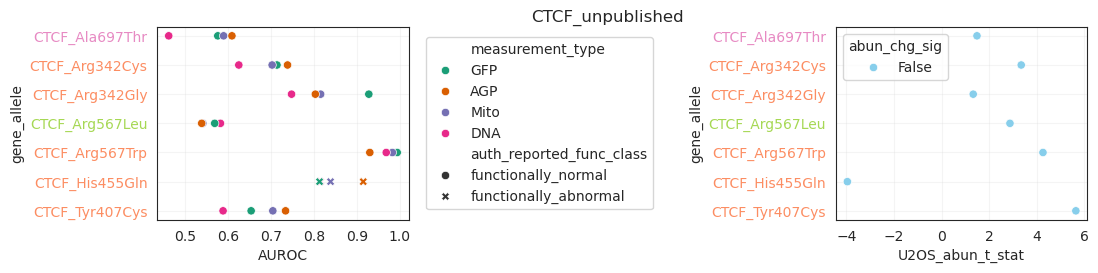

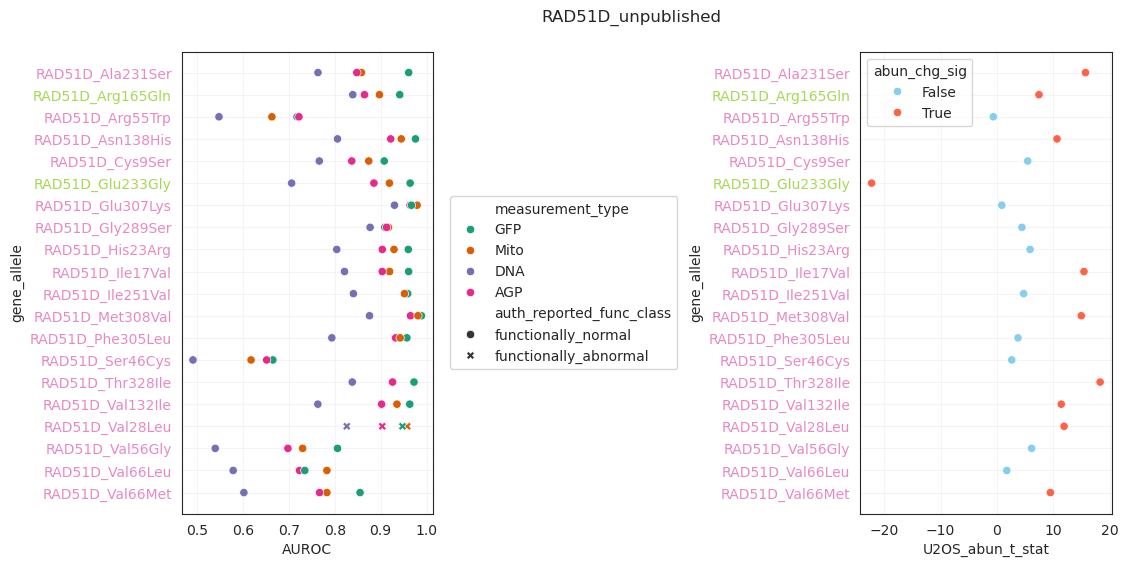

In [351]:
clinvar_color_map = palette_dict["clinvar_clnsig_clean"]
for gene in sorted(imaging_summary_clinvar_pillar_snp_match_df.unique("Gene")["Gene"]):
    if gene == "F9":
        continue
    imaging_summary_clinvar_pillar_snp_match_df_gene = imaging_summary_clinvar_pillar_snp_match_df.filter(
        pl.col("Gene")==gene
    )
    studies_on_gene = imaging_summary_clinvar_pillar_snp_match_df_gene["Dataset"].unique().to_list()
    unique_variants_per_gene = imaging_summary_clinvar_pillar_snp_match_df_gene["gene_allele"].unique().to_list()
    print(unique_variants_per_gene)
    # print(gene, "Studies on gene:", )
    # display(
    #     imaging_summary_clinvar_pillar_snp_match_df_gene.select([
    #         col for col in imaging_summary_clinvar_pillar_snp_match_df_gene.columns 
    #         if imaging_summary_clinvar_pillar_snp_match_df_gene.select(pl.col(col).is_null().all()).item() is False
    #     ])
    # )
    if gene == "BRCA1":
        studies_on_gene = [study for study in studies_on_gene if "Findlay" in study]
        
    imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull = imaging_summary_clinvar_pillar_snp_match_df_gene.select([
        col for col in imaging_summary_clinvar_pillar_snp_match_df_gene.columns 
        if imaging_summary_clinvar_pillar_snp_match_df_gene.select(pl.col(col).is_null().all()).item() is False
    ])
    if "auth_reported_func_class" in imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.columns:
        fig, axes = plt.subplots(1, 2, figsize=(12, max(2.5,len(unique_variants_per_gene)//3)))
        plot_data = imaging_summary_clinvar_pillar_snp_match_df_gene.unpivot(
           index=["gene_allele","auth_reported_func_class", "clinvar_clnsig_clean"],
           on=[f"AUROC_Mean_{feat}" for feat in FEAT_SETS],
           variable_name="measurement_type",
           value_name="AUROC"
        ).with_columns(
           pl.col("measurement_type").str.split("_").list.last().alias("measurement_type")
        ).to_pandas()
        sns.scatterplot(
            data=plot_data.sort_values("gene_allele"),
            y="gene_allele",
            x="AUROC",
            hue="measurement_type",
            style="auth_reported_func_class",
            ax=axes[0],
            palette="Dark2",
            # order=sorted(imaging_summary_clinvar_pillar_snp_match_df_gene["gene_allele"].unique())
        )
        sns.scatterplot(
            data=imaging_summary_clinvar_pillar_snp_match_df_gene.with_columns(
                (pl.col("U2OS_abun_t_pval")*imaging_summary_clinvar.shape[0]).alias("adj_pval")
            ).with_columns(
                pl.when(pl.col("adj_pval")<0.05)
                .then(True)
                .otherwise(False)
                .alias("abun_chg_sig")
            ).sort("gene_allele").to_pandas(),
            x="U2OS_abun_t_stat",
            y="gene_allele",
            hue="abun_chg_sig",
            palette={True: "tomato", False: "skyblue"},
            ax=axes[1],
            # order=sorted(imaging_summary_clinvar_pillar_snp_match_df_gene["gene_allele"].unique())
        )
        for ax in axes:
            ax.grid(alpha=.2)
        axes[0].legend(loc="center right", bbox_to_anchor=(2.,0.5))
        # Color the y-axis tick labels based on clinvar classification
        for tick, gene_allele in zip(axes[0].get_yticklabels(), plot_data["gene_allele"]):
            clinvar_class = plot_data[plot_data["gene_allele"]==gene_allele]['clinvar_clnsig_clean'].iloc[0]
            tick.set_color(clinvar_color_map[clinvar_class])
        for tick, gene_allele in zip(axes[1].get_yticklabels(), plot_data["gene_allele"]):
            clinvar_class = plot_data[plot_data["gene_allele"]==gene_allele]['clinvar_clnsig_clean'].iloc[0]
            tick.set_color(clinvar_color_map[clinvar_class])
        plt.suptitle(studies_on_gene[0],y=.95)
        plt.subplots_adjust(wspace=1.7)
        # break
    # else:
    #     fig, axes = plt.subplots(1, 5, figsize=(17, 3.5)) ##sharey=True, 
    #     imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull = imaging_summary_clinvar_pillar_snp_match_df_gene.select([
    #         col for col in imaging_summary_clinvar_pillar_snp_match_df_gene.columns 
    #         if imaging_summary_clinvar_pillar_snp_match_df_gene.select(pl.col(col).is_null().all()).item() is False
    #     ]).with_columns(
    #         pl.col("auth_reported_score").cast(pl.Float64).alias("auth_reported_score")
    #     )
    #     for j, feat in enumerate(FEAT_SETS):
    #         sns.regplot(
    #             data=imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas(),
    #             y="auth_reported_score",
    #             x=f"AUROC_Mean_{feat}",
    #             ax=axes[j],
    #             ci=False
    #         )
    #         # Get pandas dataframe for easier indexing
    #         plot_data = imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas()
    #         # Add point labels with adjustText
    #         texts = []
    #         for idx, row in plot_data.iterrows():
    #            if not (np.isnan(row["auth_reported_score"]) or np.isnan(row[f"AUROC_Mean_{feat}"])):
    #                text = axes[j].annotate(
    #                    row["gene_allele"].split('_')[-1],
    #                    (row[f"AUROC_Mean_{feat}"], row["auth_reported_score"]),  # Swapped coordinates
    #                    fontsize=7,
    #                    color=clinvar_color_map[row["clinvar_clnsig_clean"]]
    #                )
    #                texts.append(text)
    #         adjust_text(texts, ax=axes[j], arrowprops=dict(arrowstyle='->', alpha=0.5))
    #         # Calculate Spearman correlation
    #         mask = ~(np.isnan(plot_data["auth_reported_score"]) | np.isnan(plot_data[f"AUROC_Mean_{feat}"]))
    #         rho, p_val = spearmanr(
    #            plot_data["auth_reported_score"][mask], 
    #            plot_data[f"AUROC_Mean_{feat}"][mask]
    #         )
    #         # Add correlation text to plot
    #         axes[j].text(
    #            0.03, 0.15, 
    #            f'Spearman\'s ρ = {rho:.3f}\np = {p_val:.3e}',
    #            transform=axes[j].transAxes,
    #            verticalalignment='top', fontsize=7,
    #            # bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    #         )
    #         if j == 0:
    #            axes[j].set_ylabel(f"auth_reported_score")
    #         else:
    #            axes[j].set_ylabel("")
    #         axes[j].grid(alpha=.2)
    #     plt.suptitle(studies_on_gene[0],y=.95)
    #     plt.subplots_adjust(wspace=0.2)

In [194]:
feat_df = pl.read_csv("/home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/3_outputs/feat_importance_gt1e-3_all_alleles.csv")
sc_profile_feat_orig = pl.read_parquet(
    "/home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/2_analysis/1_snakemake_pipeline/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/ref_var_gfp_feat_sc_cp_profiles_oneperc.parquet")
sc_profile_feat_orig_b1314 = pl.read_parquet(
    "/home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/2_analysis/1_snakemake_pipeline/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/batch_profiles/2025_01_27_Batch_13/profiles_tcdropped_filtered_var_mad.parquet"
)
sc_profile_feat = pl.read_parquet("/home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/2_analysis/1_snakemake_pipeline/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/ref_var_gfp_feat_sc_cp_profiles_oneperc_int_featselect.parquet")

/tmp/ipykernel_53802/1039267271.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_53802/1039267271.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


[Text(0, 0, 'CTCF'),
 Text(1, 0, 'CTCF_Ala697Thr'),
 Text(2, 0, 'CTCF_Arg342Cys'),
 Text(3, 0, 'CTCF_Arg342Gly'),
 Text(4, 0, 'CTCF_Arg567Leu'),
 Text(5, 0, 'CTCF_Arg567Trp'),
 Text(6, 0, 'CTCF_Asp46Asn'),
 Text(7, 0, 'CTCF_His455Gln'),
 Text(8, 0, 'CTCF_Pro643Ser'),
 Text(9, 0, 'CTCF_Tyr226Cys'),
 Text(10, 0, 'CTCF_Tyr407Cys')]

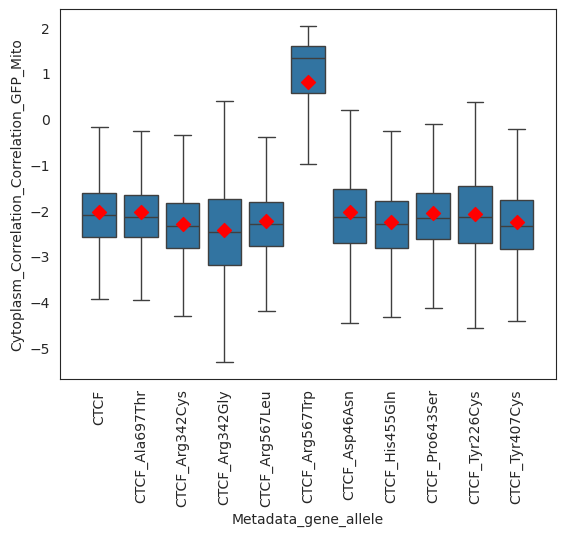

In [365]:
ax = sns.boxplot(
    data=sc_profile_feat_orig.filter(
        pl.col("Metadata_gene_allele").str.contains("CTCF")
    ).to_pandas(),
    x="Metadata_gene_allele",
    y="Cytoplasm_Correlation_Correlation_GFP_Mito",
    showfliers=False,
    order=sorted(sc_profile_feat_orig.filter(
        pl.col("Metadata_gene_allele").str.contains("CTCF")
    )["Metadata_gene_allele"].unique())
    # hue="Metadata_gene_allele",
    # hue_order=sorted(sc_profile_feat_orig.filter(
    #     pl.col("Metadata_gene_allele").str.contains("BAP1")
    # )["Metadata_gene_allele"].unique())
)
# ax.set_yscale("log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# Add mean points
data_for_plot = sc_profile_feat_orig.filter(
   pl.col("Metadata_gene_allele").str.contains("CTCF")
).to_pandas()

means = data_for_plot.groupby("Metadata_gene_allele")["Cytoplasm_Correlation_Correlation_GFP_Mito"].mean()
order = sorted(sc_profile_feat_orig.filter(
   pl.col("Metadata_gene_allele").str.contains("CTCF")
)["Metadata_gene_allele"].unique())
for i, allele in enumerate(order):
   ax.scatter(i, means[allele], color='red', s=50, marker='D', zorder=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# sns.displot(
#     data=sc_profile_feat_orig_b1314.filter(
#         pl.col("Metadata_gene_allele").is_in(['G6PD', 'G6PD_Arg365His', 'G6PD_Ile48Thr', 'G6PD_Gly378Ser', 'G6PD_Glu398Lys'])
#     ).to_pandas(),
#     x="Cytoplasm_Correlation_RWC_DNA_GFP",
#     hue="Metadata_gene_allele",
#     common_norm=False,
#     kde=True
# )

In [364]:
feat_df[["cp_feature"]+[idx for idx in feat_df.columns if "CTCF" in idx]].with_columns(
    pl.mean_horizontal(pl.col(
        ['CTCF_Arg342Cys', 'CTCF_His455Gln', 'CTCF_Arg567Leu', 'CTCF_Arg567Trp', 'CTCF_Tyr407Cys', 'CTCF_Arg342Gly', 'CTCF_Ala697Thr']
    )
).alias('row_mean')
).sort("CTCF_Arg567Trp", descending=True).drop_nulls(
    pl.col(['CTCF_Arg342Cys', 'CTCF_His455Gln', 'CTCF_Arg567Leu', 'CTCF_Arg567Trp', 'CTCF_Tyr407Cys', 'CTCF_Arg342Gly', 'CTCF_Ala697Thr'])
)["cp_feature"].to_list()[:10]

['Cytoplasm_Correlation_Correlation_GFP_Mito',
 'Cells_Correlation_Correlation_DNA_GFP',
 'Cytoplasm_RadialDistribution_RadialCV_GFP_3of10',
 'Nuclei_Correlation_Correlation_GFP_Mito',
 'Cytoplasm_RadialDistribution_RadialCV_GFP_9of10',
 'Nuclei_RadialDistribution_MeanFrac_GFP_10of10',
 'Cytoplasm_Correlation_Correlation_DNA_GFP',
 'Cells_RadialDistribution_RadialCV_GFP_10of10',
 'Nuclei_Correlation_Correlation_DNA_GFP',
 'Cells_Intensity_MaxIntensityEdge_GFP']

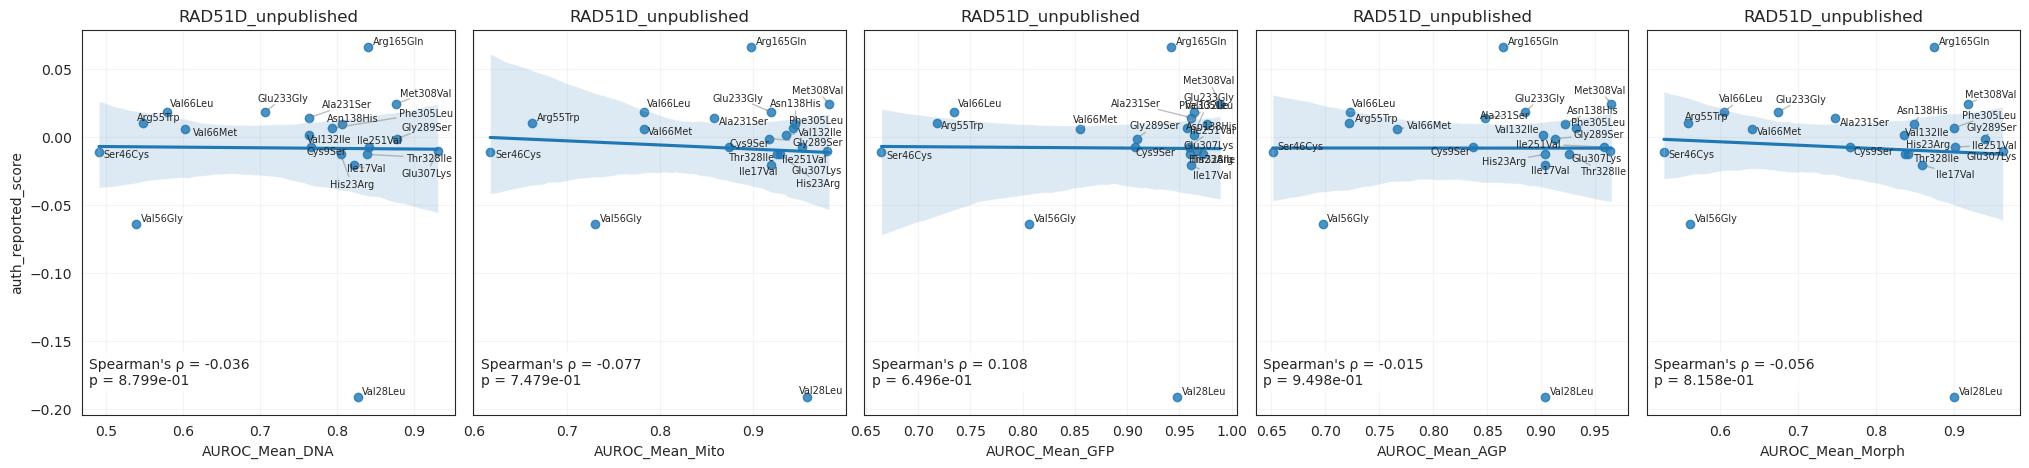

In [293]:
from scipy.stats import spearmanr
from adjustText import adjust_text

gene = "RAD51D"
imaging_summary_clinvar_pillar_snp_match_df_gene = imaging_summary_clinvar_pillar_snp_match_df.filter(
    pl.col("Gene")==gene
)
studies_on_gene = imaging_summary_clinvar_pillar_snp_match_df_gene["Dataset"].unique().to_list()
unique_variants_per_gene = imaging_summary_clinvar_pillar_snp_match_df_gene["gene_allele"].unique().to_list()

fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=True) ##, 
for j, study in enumerate(studies_on_gene):
   imaging_summary_clinvar_pillar_snp_match_df_gene_study = imaging_summary_clinvar_pillar_snp_match_df_gene.filter(
       pl.col("Dataset")==study
   )
   imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull = imaging_summary_clinvar_pillar_snp_match_df_gene_study.select([
       col for col in imaging_summary_clinvar_pillar_snp_match_df_gene_study.columns 
       if imaging_summary_clinvar_pillar_snp_match_df_gene_study.select(pl.col(col).is_null().all()).item() is False
   ]).with_columns(
       pl.col("auth_reported_score").cast(pl.Float64).alias("auth_reported_score")
   )
   for i, feat in enumerate(FEAT_SETS):
       sns.regplot(
           data=imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas(),
           y="auth_reported_score",
           x=f"AUROC_Mean_{feat}",
           ax=axes[i],
       )
       
       # Get pandas dataframe for easier indexing
       plot_data = imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas()
       
       # Add point labels with adjustText
       texts = []
       for idx, row in plot_data.iterrows():
           if not (np.isnan(row["auth_reported_score"]) or np.isnan(row[f"AUROC_Mean_{feat}"])):
               text = axes[i].annotate(
                   row["gene_allele"].split('_')[-1],
                   (row[f"AUROC_Mean_{feat}"], row["auth_reported_score"]),
                   fontsize=7
               )
               texts.append(text)
       
       adjust_text(texts, ax=axes[i], arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))
       
       # Calculate Spearman correlation
       mask = ~(np.isnan(plot_data["auth_reported_score"]) | np.isnan(plot_data[f"AUROC_Mean_{feat}"]))
       rho, p_val = spearmanr(
           plot_data["auth_reported_score"][mask], 
           plot_data[f"AUROC_Mean_{feat}"][mask]
       )
       
       # Add correlation text to plot
       axes[i].text(
           0.02, 0.15, 
           f'Spearman\'s ρ = {rho:.3f}\np = {p_val:.3e}',
           transform=axes[i].transAxes,
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
       )
       if i == 0:
           axes[i].set_ylabel(f"auth_reported_score")
       else:
           axes[i].set_ylabel("")
       axes[i].set_title(study)
       axes[i].grid(alpha=.2)

plt.subplots_adjust(wspace=0.05, hspace=0.22)

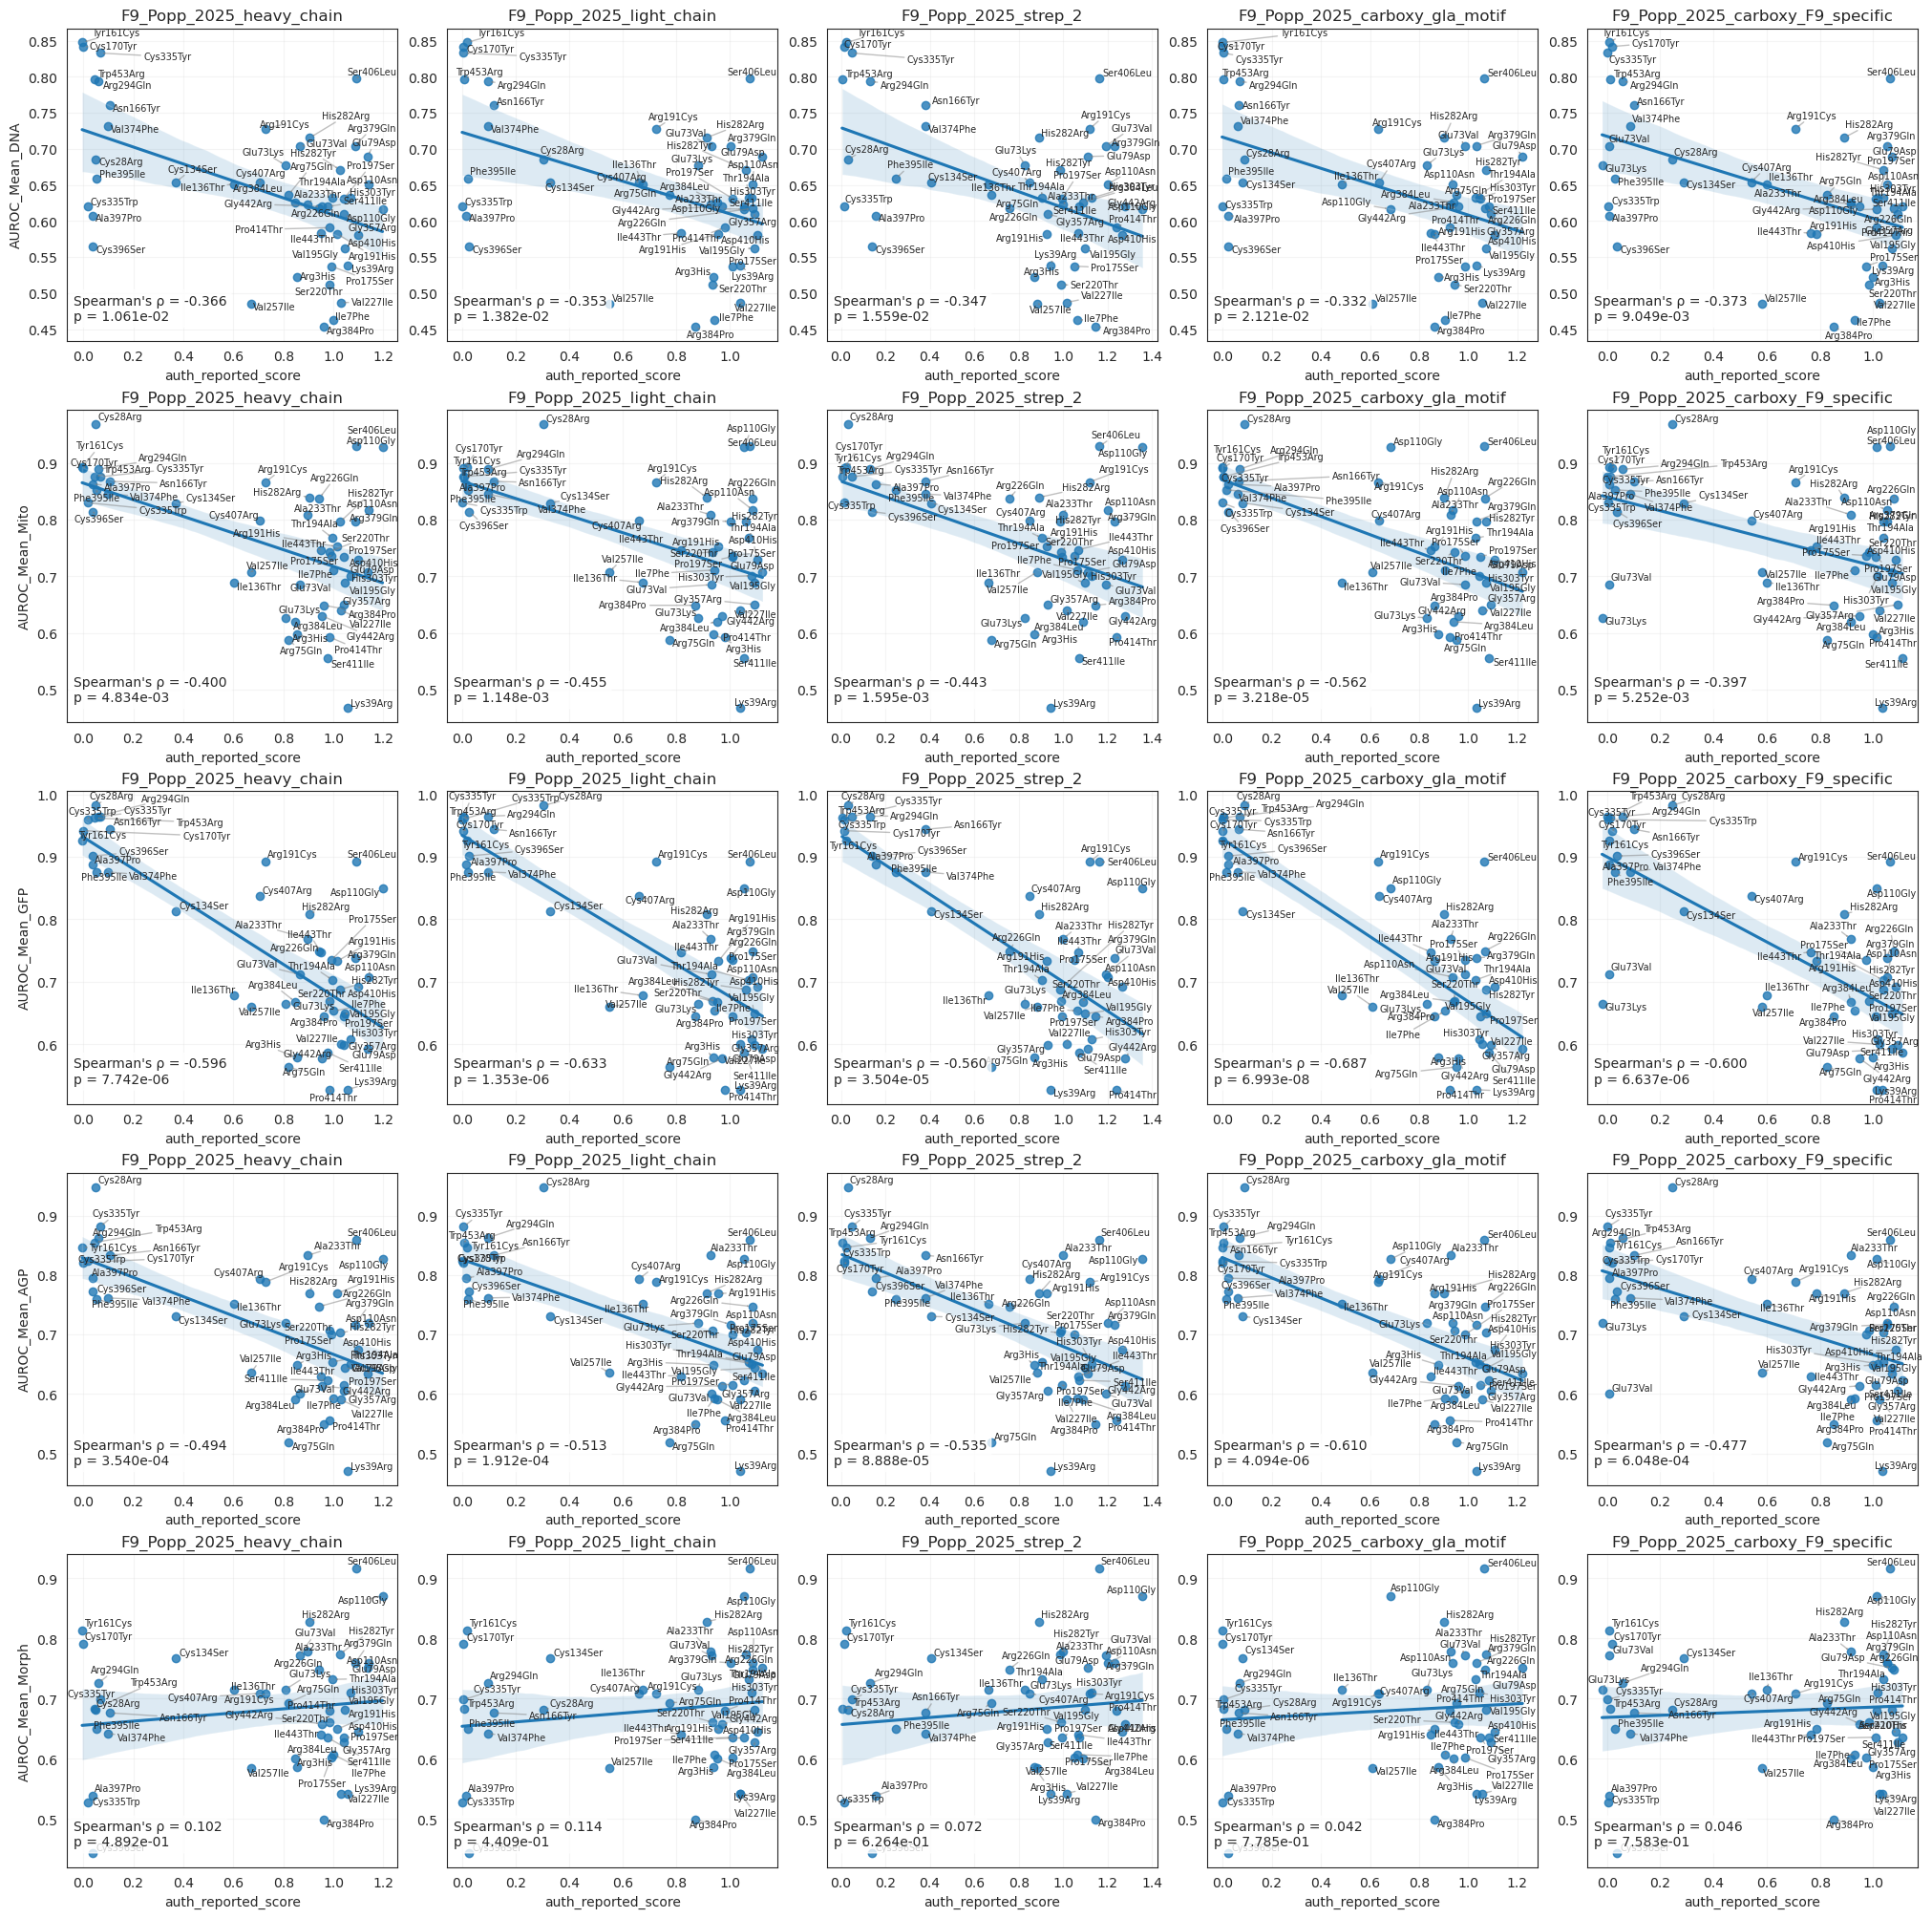

In [131]:
from scipy.stats import spearmanr
from adjustText import adjust_text

gene = "F9"
imaging_summary_clinvar_pillar_snp_match_df_gene = imaging_summary_clinvar_pillar_snp_match_df.filter(
    pl.col("Gene")==gene
)
studies_on_gene = imaging_summary_clinvar_pillar_snp_match_df_gene["Dataset"].unique().to_list()
unique_variants_per_gene = imaging_summary_clinvar_pillar_snp_match_df_gene["gene_allele"].unique().to_list()

fig, axes = plt.subplots(5, len(studies_on_gene), figsize=(25, max(2.5,len(unique_variants_per_gene)/2))) ##sharey=True, 
for j, study in enumerate(studies_on_gene):
   imaging_summary_clinvar_pillar_snp_match_df_gene_study = imaging_summary_clinvar_pillar_snp_match_df_gene.filter(
       pl.col("Dataset")==study
   )
   imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull = imaging_summary_clinvar_pillar_snp_match_df_gene_study.select([
       col for col in imaging_summary_clinvar_pillar_snp_match_df_gene_study.columns 
       if imaging_summary_clinvar_pillar_snp_match_df_gene_study.select(pl.col(col).is_null().all()).item() is False
   ]).with_columns(
       pl.col("auth_reported_score").cast(pl.Float64).alias("auth_reported_score")
   )
   for i, feat in enumerate(FEAT_SETS):
       sns.regplot(
           data=imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas(),
           x="auth_reported_score",
           y=f"AUROC_Mean_{feat}",
           ax=axes[i, j],
       )
       
       # Get pandas dataframe for easier indexing
       plot_data = imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas()
       
       # Add point labels with adjustText
       texts = []
       for idx, row in plot_data.iterrows():
           if not (np.isnan(row["auth_reported_score"]) or np.isnan(row[f"AUROC_Mean_{feat}"])):
               text = axes[i, j].annotate(
                   row["gene_allele"].split('_')[-1],
                   (row["auth_reported_score"], row[f"AUROC_Mean_{feat}"]),
                   fontsize=7
               )
               texts.append(text)
       
       adjust_text(texts, ax=axes[i, j], arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))
       
       # Calculate Spearman correlation
       mask = ~(np.isnan(plot_data["auth_reported_score"]) | np.isnan(plot_data[f"AUROC_Mean_{feat}"]))
       rho, p_val = spearmanr(
           plot_data["auth_reported_score"][mask], 
           plot_data[f"AUROC_Mean_{feat}"][mask]
       )
       
       # Add correlation text to plot
       axes[i, j].text(
           0.02, 0.15, 
           f'Spearman\'s ρ = {rho:.3f}\np = {p_val:.3e}',
           transform=axes[i, j].transAxes,
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
       )
       if j == 0:
           axes[i, j].set_ylabel(f"AUROC_Mean_{feat}")
       else:
           axes[i, j].set_ylabel("")
       axes[i, j].set_title(study)
       axes[i, j].grid(alpha=.2)

plt.subplots_adjust(wspace=0.15, hspace=0.22)

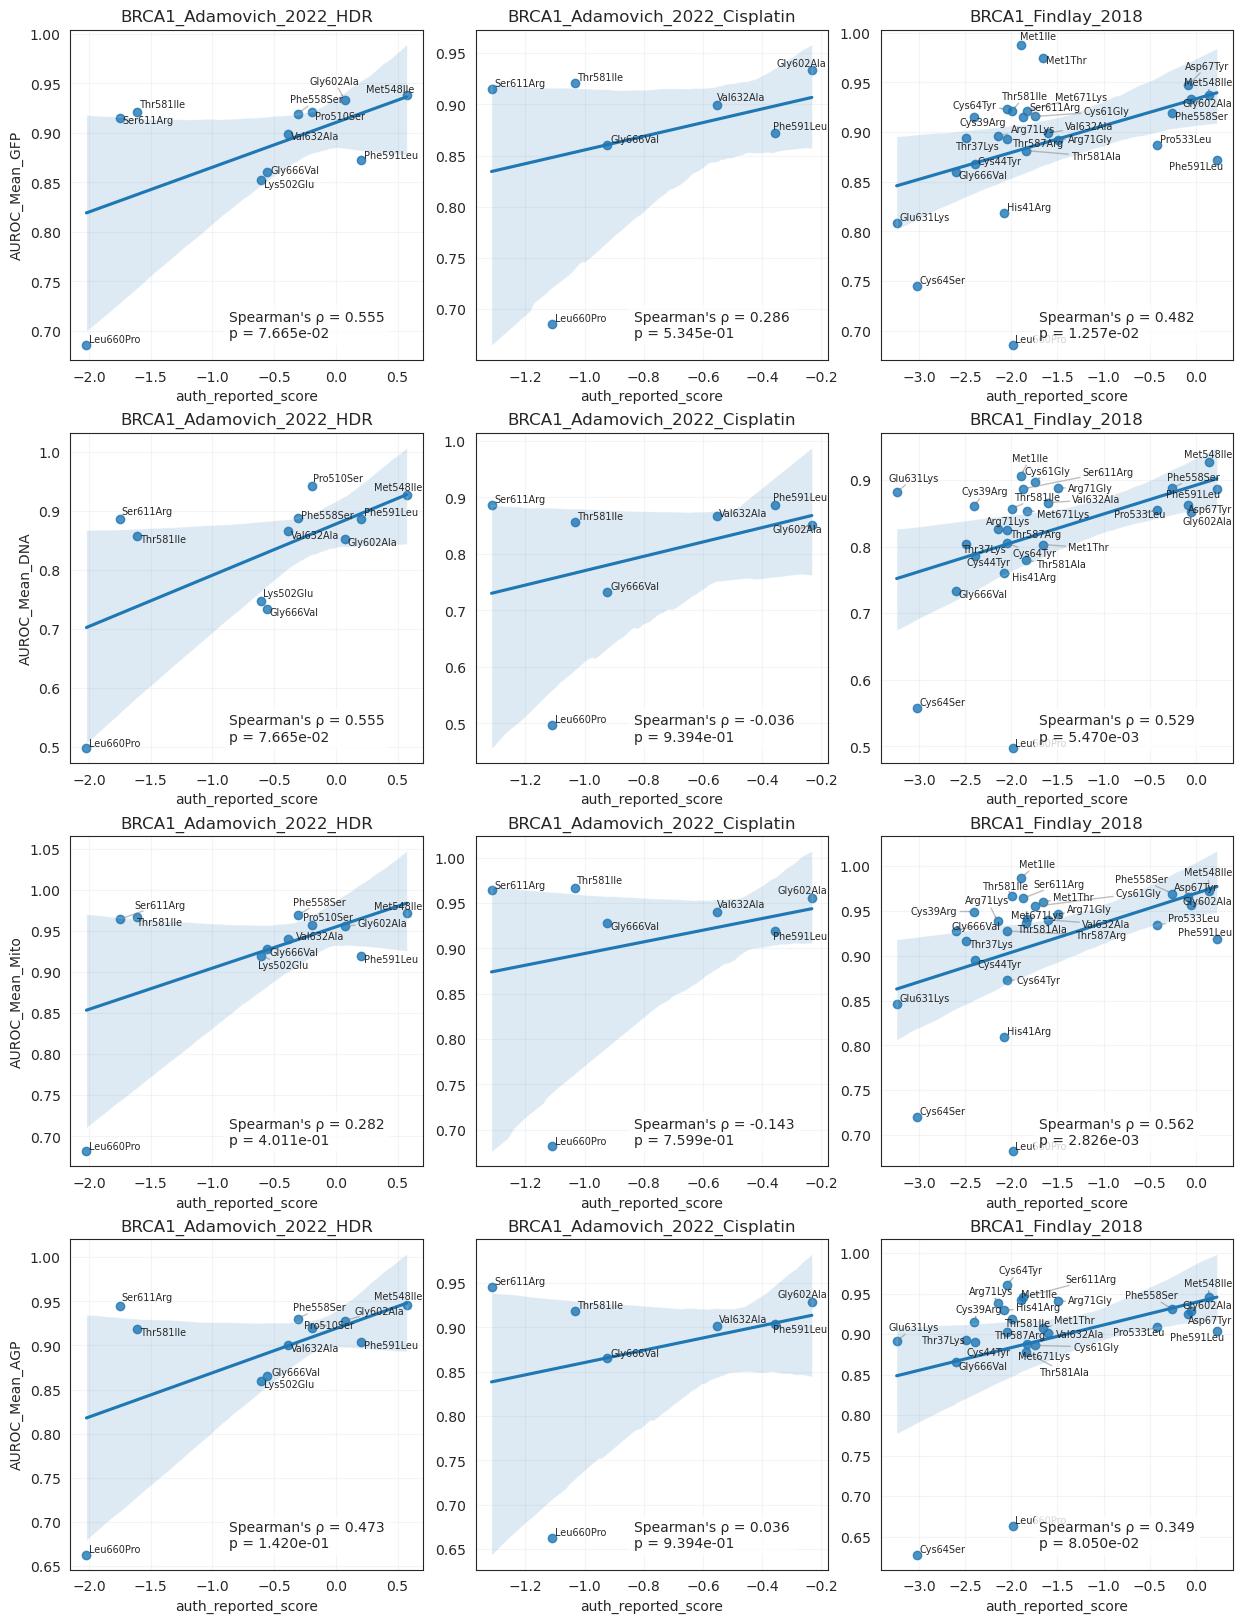

In [369]:
gene = "BRCA1"
imaging_summary_clinvar_pillar_snp_match_df_gene = imaging_summary_clinvar_pillar_snp_match_df.filter(
    pl.col("Gene")==gene
)
studies_on_gene = imaging_summary_clinvar_pillar_snp_match_df_gene["Dataset"].unique().to_list()
unique_variants_per_gene = imaging_summary_clinvar_pillar_snp_match_df_gene["gene_allele"].unique().to_list()

fig, axes = plt.subplots(4, len(studies_on_gene), figsize=(15, 20)) ##sharey=True, 
for j, study in enumerate(studies_on_gene):
   imaging_summary_clinvar_pillar_snp_match_df_gene_study = imaging_summary_clinvar_pillar_snp_match_df_gene.filter(
       pl.col("Dataset")==study
   )
   imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull = imaging_summary_clinvar_pillar_snp_match_df_gene_study.select([
       col for col in imaging_summary_clinvar_pillar_snp_match_df_gene_study.columns 
       if imaging_summary_clinvar_pillar_snp_match_df_gene_study.select(pl.col(col).is_null().all()).item() is False
   ]).with_columns(
       pl.col("auth_reported_score").cast(pl.Float64).alias("auth_reported_score")
   )
   for i, feat in enumerate(FEAT_SETS):
       sns.regplot(
           data=imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas(),
           x="auth_reported_score",
           y=f"AUROC_Mean_{feat}",
           ax=axes[i, j],
       )
       
       # Get pandas dataframe for easier indexing
       plot_data = imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas()
       
       # Add point labels with adjustText
       texts = []
       for idx, row in plot_data.iterrows():
           if not (np.isnan(row["auth_reported_score"]) or np.isnan(row[f"AUROC_Mean_{feat}"])):
               text = axes[i, j].annotate(
                   row["gene_allele"].split('_')[-1],
                   (row["auth_reported_score"], row[f"AUROC_Mean_{feat}"]),
                   fontsize=7
               )
               texts.append(text)
       
       adjust_text(texts, ax=axes[i, j], arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))
       
       # Calculate Spearman correlation
       mask = ~(np.isnan(plot_data["auth_reported_score"]) | np.isnan(plot_data[f"AUROC_Mean_{feat}"]))
       rho, p_val = spearmanr(
           plot_data["auth_reported_score"][mask], 
           plot_data[f"AUROC_Mean_{feat}"][mask]
       )
       
       # Add correlation text to plot
       axes[i, j].text(
           0.45, 0.15, 
           f'Spearman\'s ρ = {rho:.3f}\np = {p_val:.3e}',
           transform=axes[i, j].transAxes,
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
       )
       if j == 0:
           axes[i, j].set_ylabel(f"AUROC_Mean_{feat}")
       else:
           axes[i, j].set_ylabel("")
       axes[i, j].set_title(study)
       axes[i, j].grid(alpha=.2)

plt.subplots_adjust(wspace=0.15, hspace=0.22)

#### Mismatched gene_variants despite matched nuc loc

__All BRCA1 alleles__

In [132]:
imaging_summary_clinvar_pillar_snp_mismatch_df = imaging_summary_clinvar.join(
    pillar_clinvar_single_aa_df,
    on=["Chrom", "nuc_loc", "ref_allele", "alt_allele"],
    suffix="_pp",
    how="inner"
).filter(
    pl.col("gene_allele")!=pl.col("gene_variant_pp")
)
imaging_summary_clinvar_pillar_snp_mismatch_df.unique("gene_allele")

shape: (16, 1_007)
┌───────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ Gene  ┆ gene_allel ┆ U2OS_cc_t_ ┆ U2OS_cc_t_ ┆ … ┆ Updated_C ┆ Updated_E ┆ gene_vari ┆ aa_change │
│ ---   ┆ e          ┆ stat       ┆ pval       ┆   ┆ lassifica ┆ vidence   ┆ ant_pp    ┆ _pp       │
│ str   ┆ ---        ┆ ---        ┆ ---        ┆   ┆ tion_Clin ┆ Codes_Cli ┆ ---       ┆ ---       │
│       ┆ str        ┆ f64        ┆ f64        ┆   ┆ Gen…      ┆ nGen…     ┆ str       ┆ str       │
│       ┆            ┆            ┆            ┆   ┆ ---       ┆ ---       ┆           ┆           │
│       ┆            ┆            ┆            ┆   ┆ str       ┆ str       ┆           ┆           │
╞═══════╪════════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ BRCA1 ┆ BRCA1_Leu6 ┆ 0.772229   ┆ 0.465247   ┆ … ┆ null      ┆ null      ┆ BRCA1_Leu ┆ Leu1764Pr │
│       ┆ 60Pro      ┆            ┆            ┆   ┆           ┆           ┆ 1764Pro   ┆ o         │
│ BRCA1 ┆ BRCA1_Gly6 ┆ 0.811185   ┆ 0.443962   ┆ … ┆ null      ┆ null      ┆ BRCA1_Gly ┆ Gly1770Va │
│       ┆ 66Val      ┆            ┆            ┆   ┆           ┆           ┆ 1770Val   ┆ l         │
│ BRCA1 ┆ BRCA1_Glu6 ┆ 1.098339   ┆ 0.308393   ┆ … ┆ null      ┆ null      ┆ BRCA1_Glu ┆ Glu1735Ly │
│       ┆ 31Lys      ┆            ┆            ┆   ┆           ┆           ┆ 1735Lys   ┆ s         │
│ BRCA1 ┆ BRCA1_Pro5 ┆ -0.75282   ┆ 0.476108   ┆ … ┆ null      ┆ null      ┆ BRCA1_Pro ┆ Pro1637Le │
│       ┆ 33Leu      ┆            ┆            ┆   ┆           ┆           ┆ 1637Leu   ┆ u         │
│ BRCA1 ┆ BRCA1_Gly6 ┆ 3.45888    ┆ 0.010564   ┆ … ┆ null      ┆ null      ┆ BRCA1_Gly ┆ Gly1706Al │
│       ┆ 02Ala      ┆            ┆            ┆   ┆           ┆           ┆ 1706Ala   ┆ a         │
│ …     ┆ …          ┆ …          ┆ …          ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ BRCA1 ┆ BRCA1_Thr5 ┆ 2.126529   ┆ 0.071033   ┆ … ┆ null      ┆ null      ┆ BRCA1_Thr ┆ Thr1685Il │
│       ┆ 81Ile      ┆            ┆            ┆   ┆           ┆           ┆ 1685Ile   ┆ e         │
│ BRCA1 ┆ BRCA1_Met5 ┆ 0.28732    ┆ 0.782186   ┆ … ┆ null      ┆ null      ┆ BRCA1_Met ┆ Met1652Il │
│       ┆ 48Ile      ┆            ┆            ┆   ┆           ┆           ┆ 1652Ile   ┆ e         │
│ BRCA1 ┆ BRCA1_Thr5 ┆ 0.049709   ┆ 0.961743   ┆ … ┆ null      ┆ null      ┆ BRCA1_Thr ┆ Thr1685Al │
│       ┆ 81Ala      ┆            ┆            ┆   ┆           ┆           ┆ 1685Ala   ┆ a         │
│ BRCA1 ┆ BRCA1_Ser6 ┆ 0.943565   ┆ 1.0        ┆ … ┆ null      ┆ null      ┆ BRCA1_Ser ┆ Ser1715Ar │
│       ┆ 11Arg      ┆            ┆            ┆   ┆           ┆           ┆ 1715Arg   ┆ g         │
│ BRCA1 ┆ BRCA1_Phe5 ┆ 1.619363   ┆ 0.149401   ┆ … ┆ null      ┆ null      ┆ BRCA1_Phe ┆ Phe1695Le │
│       ┆ 91Leu      ┆            ┆            ┆   ┆           ┆           ┆ 1695Leu   ┆ u         │
└───────┴────────────┴────────────┴────────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [135]:
imaging_summary_clinvar.join(
    pillar_clinvar_single_aa_df,
    on=["Chrom", "nuc_loc", "ref_allele", "alt_allele"],
    suffix="_pp",
    how="inner"
).filter(
    pl.col("Gene")=="BRCA1"
).with_columns(
    pl.when(pl.col("gene_allele")!=pl.col("gene_variant_pp"))
    .then(False)
    .otherwise(True)
    .alias("Pillar_VarChAMP_Match")
).unique("gene_allele").write_csv("../../3_outputs/brca1_alleles.csv")

In [55]:
# imaging_summary_clinvar.join(
#     pillar_clinvar_df,
#     left_on="gene_allele",
#     right_on="gene_variant",
#     suffix="_pp",
#     how="inner"
# ).unique("gene_allele")

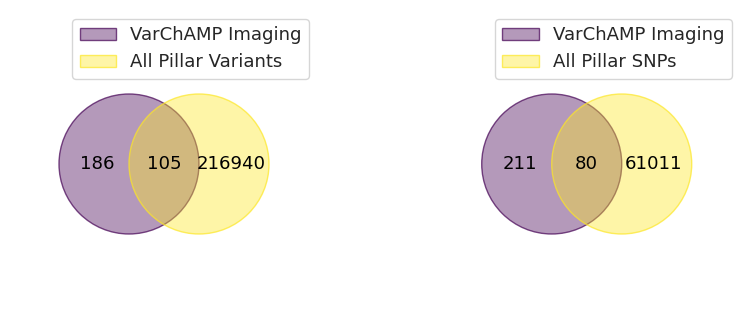

In [31]:
from venn import venn
img_pp_set = {
    'VarChAMP Imaging': set(imaging_summary_clinvar["gene_allele"].unique()),
    'All Pillar Variants': set(pillar_clinvar_df["gene_variant"].unique())
}
img_pp_snp_set = {
    'VarChAMP Imaging': set(imaging_summary_clinvar["gene_allele"].unique()),
    'All Pillar SNPs': set(pillar_clinvar_single_aa_df["gene_variant"].unique())
}
fig, axes = plt.subplots(1,2,figsize=(10,4))
venn(img_pp_set, ax=axes[0])
venn(img_pp_snp_set, ax=axes[1])
plt.show()

In [32]:
imaging_summary_clinvar_pp = imaging_summary_clinvar.join(
    pillar_clinvar_df.select(["gene_variant"]+[c for c in pillar_clinvar_df.columns if c not in imaging_summary_clinvar.columns]),
    left_on="gene_allele",
    right_on="gene_variant",
    how="inner",
    coalesce=True
)

<Figure size 640x480 with 0 Axes>

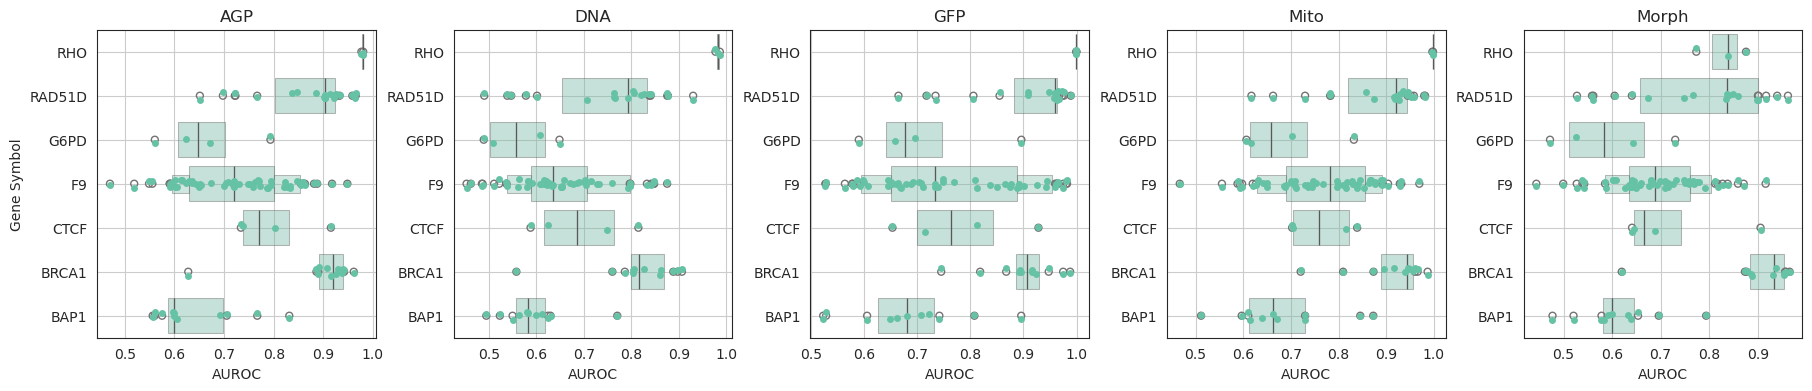

In [33]:
plt.clf()
gene_order_pillar = imaging_summary_clinvar_pp.sort("Gene").unique("Gene")["Gene"]
fig, ax = plt.subplots(1,5,figsize=(22, 4))
for i, col in enumerate(auroc_cols):
    sns.boxenplot(data=imaging_summary_clinvar_pp.unique("gene_variant").to_pandas(),
                  # palette=palette_dict["clinvar_clnsig_clean"], 
                # hue="clinvar_clnsig_clean", 
                # hue_order=hue_order,
                  color=sns.color_palette("Set2")[0],
                  order=gene_order_pillar[::-1],
                  alpha=.4,
                  # gap=.2,
                x=col, y="Gene", ax=ax[i]) #, width=.5
    sns.stripplot(data=imaging_summary_clinvar_pp.unique("gene_variant").to_pandas(),
                  # palette=palette_dict["clinvar_clnsig_clean"], 
                # hue="clinvar_clnsig_clean", 
                # hue_order=hue_order,
                  color=sns.color_palette("Set2")[0],
                  order=gene_order_pillar[::-1],
                  # gap=.2,
                x=col, y="Gene", ax=ax[i]) #, width=.5
    
    ax[i].set_xlabel("AUROC")
    ax[i].set_ylabel("")
    ax[i].set_title(col.split("_")[-1])
    ax[i].grid()
ax[0].set_ylabel("Gene Symbol")
plt.subplots_adjust(wspace=.28)
plt.show()

<Figure size 640x480 with 0 Axes>

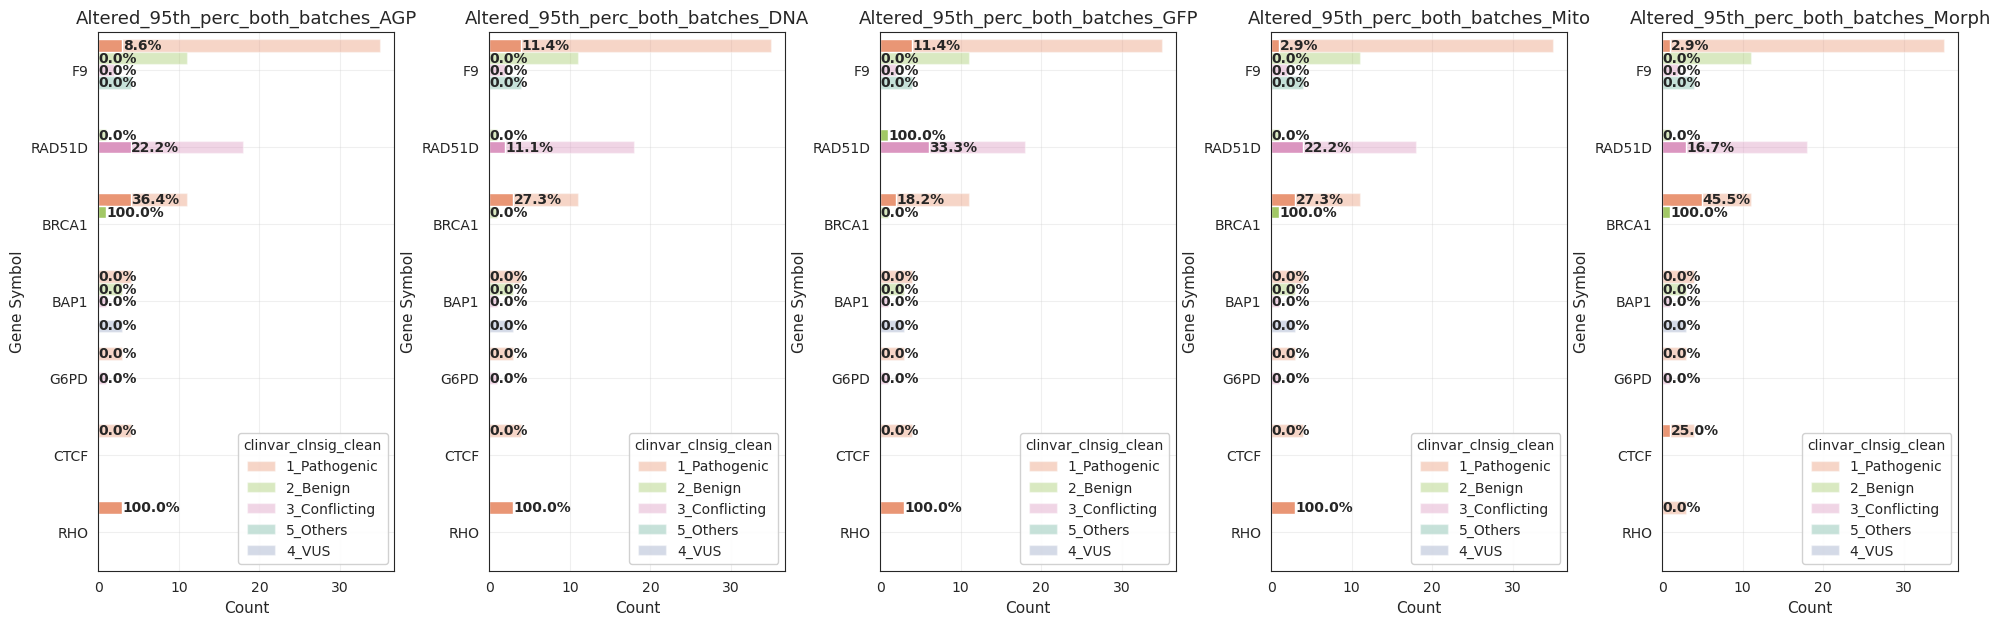

In [34]:
# plt.clf()
# fig, ax = plt.subplots(1,5,figsize=(20, 4))
# for i, col in enumerate(alter_95th_cols):
#     plot_gene_level_summary(scores.with_columns(
#         pl.col(col).cast(pl.Boolean).alias(col)
#     ), col, col+"\n", gene_order=gene_order_pillar, hits_only=False, ax=ax[i])

# # fig, ax = plt.subplots(1,1,figsize=(6,15))
# # plot_gene_level_summary(scores, "Altered_95th_perc_Morph", "Altered_95th_perc_Morph", hits_only=False, null_only=True, ax=ax)

# # fig, ax = plt.subplots(1,1,figsize=(6,4))
# # plot_gene_level_summary(func_scores, "dualipa_abund_change", "DUAL-IPA Abundance Change Pillar Variants", hits_only=False, ax=ax)
# plt.subplots_adjust(wspace=.32)
# plt.show()

plt.clf()
fig, ax = plt.subplots(1,5,figsize=(24, 7))
for i, col in enumerate(alter_95th_cols):
    plot_gene_level_summary(imaging_summary_clinvar_pp.unique("gene_variant").with_columns(
        pl.col(col).cast(pl.Boolean).alias(col)
    ), assay=col, ax=ax[i], palette=palette_dict["clinvar_clnsig_clean"]) ## gene_order=gene_order, hits_only=False,, col, col+"\n"
    ax[i].grid(alpha=.3)

plt.subplots_adjust(wspace=.32)
plt.show()

In [73]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, roc_curve
import requests
import glob
import gzip
import re
import os
import py3Dmol
from Bio.PDB import PDBParser
import requests
import gzip

def get_uniprot_swissprot_id(protein_name: str) -> str:
    """
    Query UniProt’s REST search API to find the reviewed (Swiss‐Prot) accession
    for a given human gene/protein name. Returns None if not found.
    """
    url = "https://rest.uniprot.org/uniprotkb/search"
    # Build a query that:
    #  - matches the gene name exactly (using “gene:”)
    #  - restricts to human (organism_id:9606)
    #  - restricts to reviewed (Swiss‐Prot) entries
    query = f"gene:{protein_name} AND organism_id:9606 AND reviewed:true"
    params = {
        "query": query,
        "fields": "accession",
        "format": "json",
        "size": 1,      # only need the top hit
    }
    try:
        resp = requests.get(url, params=params, timeout=10)
        resp.raise_for_status()
        data = resp.json()
        results = data.get("results", [])
        if not results:
            return None
        return results[0]["primaryAccession"]
    except Exception:
        # If the request fails (e.g. no internet), return None
        return None

gene = "RAD51D"
gene_uniprot_id = get_uniprot_swissprot_id(gene)
print(f"UniProt Swiss‐Prot ID for {gene}:", {gene_uniprot_id} or "Not found")

af2_struc_pdb_dir = "/data/shenrunx/igvf/varchamp/2025_laval_submitted/compare_ai_scores/1_inputs/new_raw_data/alphafold/UP000005640_9606_HUMAN_v4"

pdb_file = [pdb for pdb in glob.glob(f"{af2_struc_pdb_dir}/*.pdb.gz") if gene_uniprot_id in pdb][0]
pdb_file

# 1. Parse the structure
# 1) Open the .pdb.gz file with gzip.open in text/binary mode:
with gzip.open(pdb_file, "rt") as handle:
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("rho", handle)

    # 3. Rewind and read the entire PDB text
    handle.seek(0)
    pdb_text = handle.read()

# 2. Build a map: residue_number → (x, y, z) of its Cα atom
ca_coords = {}
for model in structure:
    for chain in model:
        if chain.get_id() == "A":
            for residue in chain:
                resnum = residue.get_id()[1]
                # Only consider standard amino acids with a CA atom
                if 'CA' in residue:
                    atom_ca = residue['CA']
                    ca_coords[resnum] = atom_ca.get_coord()

# 2) List of variants in “RHO_AminoAcidResidueNumberNewAminoAcid” format.
#    We assume that the PDB’s residue numbering matches exactly the numbers in these strings.
variants_raw = rad51d_allele.filter(pl.col("gene_allele").str.contains(f"{gene}_"))["gene_allele"].unique()
# 3) The chain ID in the PDB that contains Rhodopsin.
#    If your PDB uses a different chain (e.g. “B”), adjust accordingly.
chain_id = "A"
# 4) If your PDB has insertion codes (e.g. 106A, 106B), you must handle that.
#    In this example, we assume no insertion codes (icode = " ").
default_icode = " "
# Confirm chain exists
model = structure[0]  # first (and usually only) model
if chain_id not in model:
    raise ValueError(f"Chain '{chain_id}' not found in {pdb_file}.")
# ---- STEP 2: Convert each raw‐string into (chain, resi, icode, label) ----
variant_list = []
pattern = re.compile(rf"{gene}_([A-Za-z]{{3}})(\d+)([A-Za-z]{{3}})")
for raw in variants_raw:
    m = pattern.match(raw)
    if not m:
        print(f"Warning: '{raw}' does not match expected pattern 'RHO_Aaa###Bbb'. Skipping.")
        continue
    wt_3letter, resi_str, mut_3letter = m.groups()
    resi = int(resi_str)
    # Convert three‐letter codes to one‐letter for a concise label if you like.
    # Here, we'll keep the original string as the label.
    label = raw
    variant_list.append({
        "chain": chain_id,
        "resi": resi,
        "icode": default_icode,
        "label": label
    })

print(variant_list)
if not variant_list:
    raise RuntimeError("No valid variants found. Please check your variant strings.")

UniProt Swiss‐Prot ID for RAD51D: {'O75771'}
[{'chain': 'A', 'resi': 231, 'icode': ' ', 'label': 'RAD51D_Ala231Ser'}, {'chain': 'A', 'resi': 46, 'icode': ' ', 'label': 'RAD51D_Ser46Cys'}, {'chain': 'A', 'resi': 9, 'icode': ' ', 'label': 'RAD51D_Cys9Ser'}, {'chain': 'A', 'resi': 308, 'icode': ' ', 'label': 'RAD51D_Met308Val'}, {'chain': 'A', 'resi': 251, 'icode': ' ', 'label': 'RAD51D_Ile251Val'}, {'chain': 'A', 'resi': 138, 'icode': ' ', 'label': 'RAD51D_Asn138His'}, {'chain': 'A', 'resi': 233, 'icode': ' ', 'label': 'RAD51D_Glu233Gly'}, {'chain': 'A', 'resi': 305, 'icode': ' ', 'label': 'RAD51D_Phe305Leu'}, {'chain': 'A', 'resi': 56, 'icode': ' ', 'label': 'RAD51D_Val56Gly'}, {'chain': 'A', 'resi': 132, 'icode': ' ', 'label': 'RAD51D_Val132Ile'}, {'chain': 'A', 'resi': 289, 'icode': ' ', 'label': 'RAD51D_Gly289Ser'}, {'chain': 'A', 'resi': 28, 'icode': ' ', 'label': 'RAD51D_Val28Leu'}, {'chain': 'A', 'resi': 66, 'icode': ' ', 'label': 'RAD51D_Val66Met'}, {'chain': 'A', 'resi': 55, 'ic

In [80]:
# Define 3D offsets for each residue
offsets_3d = {
    135: {'x': +1.0, 'y': +0.5, 'z': +0.5},
    110: {'x': -1.0, 'y': +0.5, 'z': +0.5},
    190: {'x':  0.0, 'y': -1.0, 'z': +0.5}
}

view = py3Dmol.view(width=800, height=600)
view.addModel(pdb_text, 'pdb')
view.setStyle({'cartoon': {'color': 'spectrum'}})

residues_to_label = [var['resi'] for var in variant_list]

# Define colors for each residue
residue_colors = {
    135: 'red',
    110: 'blue', 
    190: 'green'
}

# Style and label each residue individually with different colors
for resi in residues_to_label:
    color = "red" if rad51d_allele.filter(
        pl.col("gene_allele").str.contains(str(resi))
    )["Altered_95th_perc_both_batches_GFP"].to_numpy()[0] else "green"
    
    # Set sphere style for this residue
    view.setStyle({'chain': 'A', 'resi': resi}, {'sphere': {'color': color, 'radius': .5}})
    
    # Add label for this residue
    view.addResLabels(
        {'chain': 'A', 'resi': resi},
        {'fontColor': color, 'fontSize': 15, 'showBg': False}
    )

view.zoomTo()
view.show()
    
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

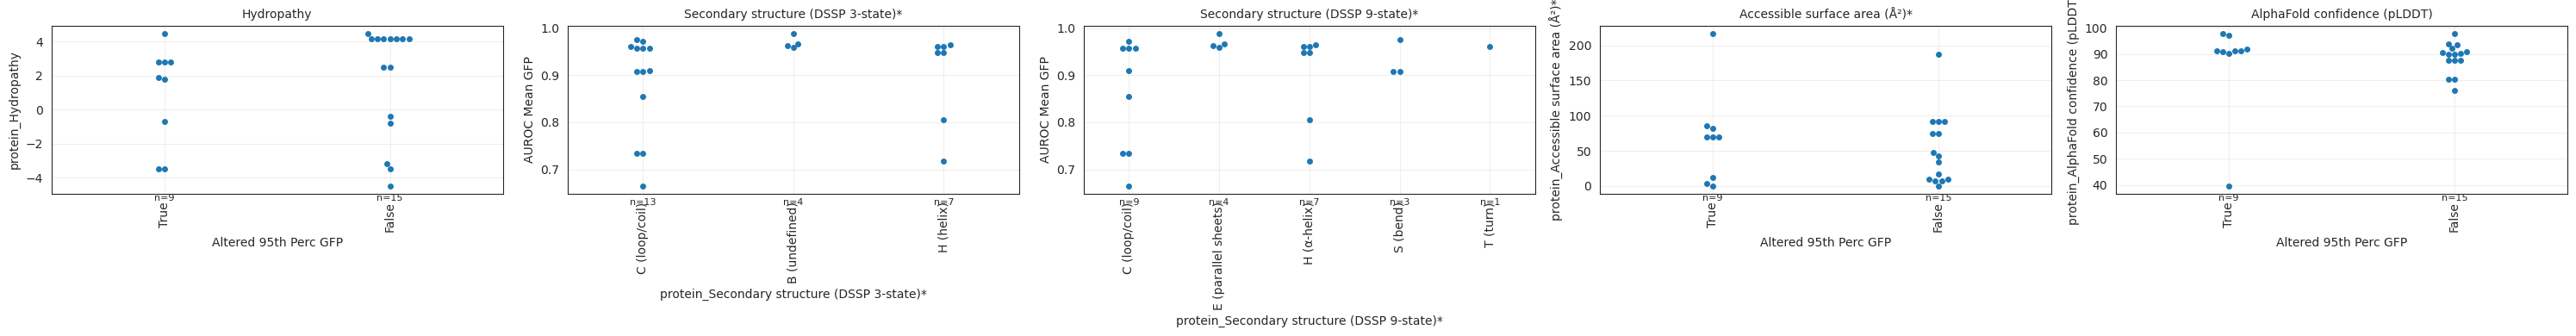

In [96]:
# Define feature categories for subcellular localization analysis
feature_categories = {
    'Signal_Sequences_Targeting': [
        'protein_Signal (UniProt)',
        'protein_Transit peptide (UniProt)', 
        'protein_Transmembrane (UniProt)',
        'protein_Topological domain (UniProt)',
        'protein_Intramembrane (UniProt)'
    ],
    
    'Nuclear_Targeting': [
        'protein_Motif (UniProt)',
        'protein_Region (UniProt)'
    ],
    
    'Structural_Context': [
        'protein_Hydropathy',
        'protein_Secondary structure (DSSP 3-state)*',
        'protein_Secondary structure (DSSP 9-state)*',
        'protein_Accessible surface area (Å²)*',
        'protein_AlphaFold confidence (pLDDT)'
    ],
    
    'Post_Translational_Modifications': [
        'protein_Lipidation (UniProt)',
        'protein_Glycosylation (UniProt)',
        'protein_Modified residue (UniProt)',
        'protein_Acetylation',
        'protein_Phosphorylation',
        'protein_Ubiquitination'
    ],
    
    'Protein_Domains_Sites': [
        'protein_Domain (UniProt)',
        'protein_Active site (UniProt)',
        'protein_Binding site (UniProt)',
        'protein_Coiled coil (UniProt)',
        'protein_Zinc finger (UniProt)'
    ]
}

def determine_feature_type(df, feature):
    """Determine if feature is categorical or continuous"""
    if feature not in df.columns:
        return None
    
    # Get non-null values
    values = df[feature].dropna()
    if len(values) == 0:
        return None
    
    # Check if numeric
    if pd.api.types.is_numeric_dtype(values):
        return 'continuous'
    else:
        return 'categorical'

def clean_categorical_data(series, max_categories=15):
    """Clean categorical data for plotting"""
    # Remove null values
    cleaned = series.dropna()
    
    # Get value counts
    value_counts = cleaned.value_counts()
    
    # If too many categories, keep top N
    if len(value_counts) > max_categories:
        top_categories = value_counts.head(max_categories).index
        cleaned = cleaned[cleaned.isin(top_categories)]
    
    return cleaned


def format_long_string(text, max_chars=50):
    """Format long strings with line breaks at word boundaries"""
    if len(str(text)) <= max_chars:
        return str(text)
    
    words = str(text).split()
    lines = []
    current_line = ""
    
    for word in words:
        if len(current_line) == 0:
            current_line = word
        elif len(current_line) + len(word) + 1 <= max_chars:
            current_line += " " + word
        else:
            lines.append(current_line)
            current_line = word
    
    if current_line:
        lines.append(current_line)
    
    return "\n".join(lines)

df = rad51d_allele.to_pandas()
figsize_per_plot=(6, 4) 

fig, axes = plt.subplots(1, 5, figsize=(figsize_per_plot[0] * 5, figsize_per_plot[1] * 1))
for i, feature in enumerate(feature_categories["Structural_Context"]):
    ax = axes[i]
    
    # Determine feature type
    feature_type = determine_feature_type(df, feature)
    
    if feature_type is None:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(feature.replace('protein_', '').replace(' (UniProt)', ''), fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        continue
    
    if feature_type == 'categorical':
        # For categorical features: boxenplot of AUROC_Mean_GFP per category
        plot_data = df[[feature, 'AUROC_Mean_GFP']].dropna()
        if len(plot_data) == 0:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            # Clean categorical data
            cleaned_feature = clean_categorical_data(plot_data[feature])
            plot_data_clean = plot_data[plot_data[feature].isin(cleaned_feature)]
            if len(plot_data_clean) == 0:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes, fontsize=12)
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                # Format long category labels
                plot_data_clean = plot_data_clean.copy()
                plot_data_clean[feature] = plot_data_clean[feature].apply(format_long_string)
                
                sns.swarmplot(data=plot_data_clean, x=feature, y='AUROC_Mean_GFP', ax=ax)
                ax.tick_params(axis='x', rotation=90, labelsize=10)
                ax.set_ylabel('AUROC Mean GFP')
                
                # Add sample sizes - get actual x-tick labels and positions
                x_labels = [tick.get_text() for tick in ax.get_xticklabels()]
                cat_counts = plot_data_clean[feature].value_counts()
                for j, label in enumerate(x_labels):
                    count = cat_counts.get(label, 0)
                    ax.text(j, ax.get_ylim()[0]-0.01, f'n={count}', ha='center', va='top', fontsize=8)
    
    else:  # continuous
        # For continuous features: boxenplot per Altered_95th_perc_both_batches_GFP category
        plot_data = df[[feature, 'Altered_95th_perc_both_batches_GFP']].dropna()
        
        if len(plot_data) == 0:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes, fontsize=10)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            # Format long category labels
            plot_data = plot_data.copy()
            plot_data['Altered_95th_perc_both_batches_GFP'] = plot_data['Altered_95th_perc_both_batches_GFP'].apply(format_long_string)
            
            sns.swarmplot(data=plot_data, x='Altered_95th_perc_both_batches_GFP', y=feature, ax=ax)
            ax.set_xlabel('Altered 95th Perc GFP')
            ax.tick_params(axis='x', rotation=90, labelsize=10)
            
            # Add sample sizes - get actual x-tick labels and positions
            x_labels = [tick.get_text() for tick in ax.get_xticklabels()]
            cat_counts = plot_data['Altered_95th_perc_both_batches_GFP'].value_counts()
            for j, label in enumerate(x_labels):
                count = cat_counts.get(label, 0)
                ax.text(j, ax.get_ylim()[0]-0.01, f'n={count}', ha='center', va='top', fontsize=8)
    
    ax.set_title(feature.replace('protein_', '').replace(' (UniProt)', ''), fontsize=10)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()